# Churn Prediction in Telecom Industry using Cell2Cell Dataset

This notebook explores customer churn in the telecom industry using the Cell2Cell dataset. It provides a comprehensive workflow for building a churn prediction model.

## Introduction
Predicting Customer Churn in the Telecom Industry Customer churn, the loss of subscribers, is a major concern for telecom companies. Retaining existing customers is often cheaper than acquiring new ones. In this notebook, we'll tackle the challenge of churn prediction using the Cell2Cell telecom dataset.

## Purpose of the project
This project aims to develop a machine learning model that can accurately predict whether a customer is likely to churn (cancel their service) based on their historical data. By understanding churn patterns, telecom companies can implement targeted retention strategies and minimize subscriber loss.

This notebook will follow a comprehensive approach, including:

- **Exploratory Data Analysis (EDA)**: We'll delve into the dataset, uncovering patterns and relationships between features and the churn target variable.
- **Data Pre-processing and Feature Engineering**: We'll clean and prepare the data for modeling, potentially creating new features to enhance predictive power.
- **Model Building and Evaluation**: We'll train and evaluate different machine learning models to identify the one that best predicts customer churn.
- Through this analysis, we hope to gain valuable insights into customer behavior and develop a robust model for churn prediction in the telecom industry.

## Imports, Functions and Data Loading

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
import xgboost as xgb
from sklearn.metrics import roc_auc_score,accuracy_score,f1_score,confusion_matrix,classification_report,recall_score
from sklearn import metrics

### Functions

In [3]:
def plot_dist(df, col = '', y_limit=None, x_limit_r=None, x_limit_l = None):
    plt.figure(figsize=(9,4))
    plt.grid(True)
    sns.distplot(df[col][df.Churn == 'Yes'])
    sns.distplot(df[col][df.Churn == 'No'])
    plt.legend(['Churn', 'Non-Churn'])

In [4]:
def distribution_categorical(df,column,custom_order = None):
    column_categories = df[column].dropna().unique()
    if custom_order == None:
        column_categories = sorted(column_categories)
        churn_counts = round(df[df['Churn']=="Yes"].groupby(column).count()['Churn']/len(df[df['Churn']=="Yes"])*100,2)
        non_churn_counts = df[df['Churn']=="No"].groupby(column).count()['Churn']/len(df[df['Churn']=="No"])*100
    else:
        column_categories = custom_order
        churn_counts = round(df[df['Churn']=="Yes"].groupby(column).count().reindex(custom_order, fill_value=0)['Churn']/len(df[df['Churn']=="Yes"])*100,2)
        non_churn_counts = df[df['Churn']=="No"].groupby(column).count().reindex(custom_order, fill_value=0)['Churn']/len(df[df['Churn']=="No"])*100
    

    bar_width = 0.35
    plt.figure(figsize=(13, 6))

    r1 = np.arange(len(column_categories))
    r2 = [x + bar_width for x in r1]

    plt.bar(column_categories, churn_counts,  width=bar_width, edgecolor='grey', label='Churn')
    plt.bar(r2, non_churn_counts,  width=bar_width, edgecolor='grey', label='Non-Churn')

    plt.xlabel(column, fontweight='bold')
    plt.ylabel('Percentage of People', fontweight='bold')
    plt.xticks([r + bar_width / 2 for r in range(len(column_categories))], column_categories)

    for i in range(len(column_categories)):
        plt.text(r1[i], churn_counts[i] + 1, f'{churn_counts[i]:.1f}%', ha='center',fontsize=9)
        plt.text(r2[i], non_churn_counts[i] + 1, f'{non_churn_counts[i]:.1f}%', ha='center',fontsize=9)

    plt.legend()

    plt.title('Distribution of the '+column+' in Churn and Non-Churn')
    plt.show()

In [5]:
def count_outliers_in_numerical_columns(df):
    outlier_counts = {}

    # Select only numerical columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    for column in numeric_cols:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outliers = (df[column] < lower_bound) | (df[column] > upper_bound)

        # Count outliers
        outlier_counts[column] = outliers.sum()

    return outlier_counts



In [6]:
def replace_outliers_with_limits(df):
    new_df = df.copy()
    
    # Select only numerical columns
    numeric_cols = new_df.select_dtypes(include=[np.number]).columns
    
    for column in numeric_cols:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outliers = (df[column] < lower_bound) | (df[column] > upper_bound)

        # Get non-outlier data to find max and min
        non_outliers = df[~outliers][column]

        # Set max and min values from non-outliers
        max_non_outlier = non_outliers.max()
        min_non_outlier = non_outliers.min()

        # Replace outliers with max or min non-outlier values
        new_df.loc[df[column] < lower_bound, column] = min_non_outlier
        new_df.loc[df[column] > upper_bound, column] = max_non_outlier

    return new_df



#### Data Loading

In [43]:
df = pd.read_csv("/kaggle/input/datasets-for-churn-telecom/cell2celltrain.csv")

In [15]:
df.shape

(51047, 58)

Our data consists of ***51,047 samples*** and ***58 features***.

## Exploratory Data Analysis (EDA)

In [44]:
df.drop(columns=['CustomerID'],inplace=True)
# df['Churn'].replace('Yes', 1, inplace=True)
# df['Churn'].replace('No', 0, inplace=True)

In [12]:
df.head()

CustomerID Churn  MonthlyRevenue  MonthlyMinutes  TotalRecurringCharge   
0     3000002   Yes           24.00           219.0                  22.0  \
1     3000010   Yes           16.99            10.0                  17.0   
2     3000014    No           38.00             8.0                  38.0   
3     3000022    No           82.28          1312.0                  75.0   
4     3000026   Yes           17.14             0.0                  17.0   

   DirectorAssistedCalls  OverageMinutes  RoamingCalls  PercChangeMinutes   
0                   0.25             0.0           0.0             -157.0  \
1                   0.00             0.0           0.0               -4.0   
2                   0.00             0.0           0.0               -2.0   
3                   1.24             0.0           0.0              157.0   
4                   0.00             0.0           0.0                0.0   

   PercChangeRevenues  ...  ReferralsMadeBySubscriber  IncomeGroup   
0               -19.0  ...                          0            4  \
1                 0.0  ...                          0            5   
2                 0.0  ...                          0            6   
3                 8.1  ...                          0            6   
4                -0.2  ...                          0            9   

   OwnsMotorcycle  AdjustmentsToCreditRating  HandsetPrice   
0              No                          0            30  \
1              No                          0            30   
2              No                          0       Unknown   
3              No                          0            10   
4              No                          1            10   

   MadeCallToRetentionTeam  CreditRating  PrizmCode    Occupation   
0                      Yes     1-Highest   Suburban  Professional  \
1                       No      4-Medium   Suburban  Professional   
2                       No        3-Good       Town        Crafts   
3                       No      4-Medium      Other         Other   
4                       No     1-Highest      Other  Professional   

   MaritalStatus  
0             No  
1            Yes  
2            Yes  
3             No  
4            Yes  

[5 rows x 58 columns]

In [401]:
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 51047 entries, 0 to 51046

Data columns (total 57 columns):

 #   Column                     Non-Null Count  Dtype  

---  ------                     --------------  -----  

 0   Churn                      51047 non-null  object 

 1   MonthlyRevenue             50891 non-null  float64

 2   MonthlyMinutes             50891 non-null  float64

 3   TotalRecurringCharge       50891 non-null  float64

 4   DirectorAssistedCalls      50891 non-null  float64

 5   OverageMinutes             50891 non-null  float64

 6   RoamingCalls               50891 non-null  float64

 7   PercChangeMinutes          50680 non-null  float64

 8   PercChangeRevenues         50680 non-null  float64

 9   DroppedCalls               51047 non-null  float64

 10  BlockedCalls               51047 non-null  float64

 11  UnansweredCalls            51047 non-null  float64

 12  CustomerCareCalls          51047 non-null  float64

 13  ThreewayCalls              5

### Checking missing values

In [402]:
df.isnull().sum()

Churn                          0
MonthlyRevenue               156
MonthlyMinutes               156
TotalRecurringCharge         156
DirectorAssistedCalls        156
OverageMinutes               156
RoamingCalls                 156
PercChangeMinutes            367
PercChangeRevenues           367
DroppedCalls                   0
BlockedCalls                   0
UnansweredCalls                0
CustomerCareCalls              0
ThreewayCalls                  0
ReceivedCalls                  0
OutboundCalls                  0
InboundCalls                   0
PeakCallsInOut                 0
OffPeakCallsInOut              0
DroppedBlockedCalls            0
CallForwardingCalls            0
CallWaitingCalls               0
MonthsInService                0
UniqueSubs                     0
ActiveSubs                     0
ServiceArea                   24
Handsets                       1
HandsetModels                  1
CurrentEquipmentDays           1
AgeHH1                       909
AgeHH2    

In [45]:
#NUll percentage in each feature
null_percentages = round((df.isnull().sum() / len(df)) * 100,2)

print(null_percentages.sort_values(ascending=False))

AgeHH2                       1.78
AgeHH1                       1.78
PercChangeMinutes            0.72
PercChangeRevenues           0.72
MonthlyMinutes               0.31
TotalRecurringCharge         0.31
DirectorAssistedCalls        0.31
OverageMinutes               0.31
RoamingCalls                 0.31
MonthlyRevenue               0.31
ServiceArea                  0.05
Churn                        0.00
OptOutMailings               0.00
OwnsComputer                 0.00
NonUSTravel                  0.00
BuysViaMailOrder             0.00
RespondsToMailOffers         0.00
RetentionCalls               0.00
Homeownership                0.00
HasCreditCard                0.00
ReferralsMadeBySubscriber    0.00
RetentionOffersAccepted      0.00
NewCellphoneUser             0.00
NotNewCellphoneUser          0.00
TruckOwner                   0.00
IncomeGroup                  0.00
OwnsMotorcycle               0.00
AdjustmentsToCreditRating    0.00
HandsetPrice                 0.00
MadeCallToRete

**Action point**: All nulls are dropped as their percent is too small compared to the whole data.

In [46]:
df.dropna(inplace=True,ignore_index=True)

df.isnull().sum()

Churn                        0
MonthlyRevenue               0
MonthlyMinutes               0
TotalRecurringCharge         0
DirectorAssistedCalls        0
OverageMinutes               0
RoamingCalls                 0
PercChangeMinutes            0
PercChangeRevenues           0
DroppedCalls                 0
BlockedCalls                 0
UnansweredCalls              0
CustomerCareCalls            0
ThreewayCalls                0
ReceivedCalls                0
OutboundCalls                0
InboundCalls                 0
PeakCallsInOut               0
OffPeakCallsInOut            0
DroppedBlockedCalls          0
CallForwardingCalls          0
CallWaitingCalls             0
MonthsInService              0
UniqueSubs                   0
ActiveSubs                   0
ServiceArea                  0
Handsets                     0
HandsetModels                0
CurrentEquipmentDays         0
AgeHH1                       0
AgeHH2                       0
ChildrenInHH                 0
HandsetR

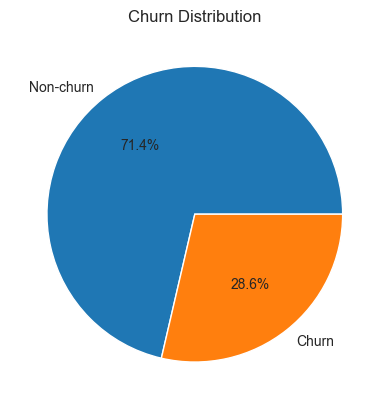

In [68]:
class_counts = df['Churn'].value_counts().sort_values(ascending=False)
class_percentages = (class_counts / len(df['Churn'])) * 100
plt.pie(percentages, labels=["Non-churn", "Churn"], autopct="%1.1f%%")
plt.title("Churn Distribution")
plt.show()

**Note:** Our data is unbalaced as there are ***71.2% Non-churn*** and ***28.6% Churn*** customers.

### 1. Distribution Visualization


Plotting histograms of numerical features

In [23]:
numerical_columns = df.select_dtypes(include=['int', 'float'])

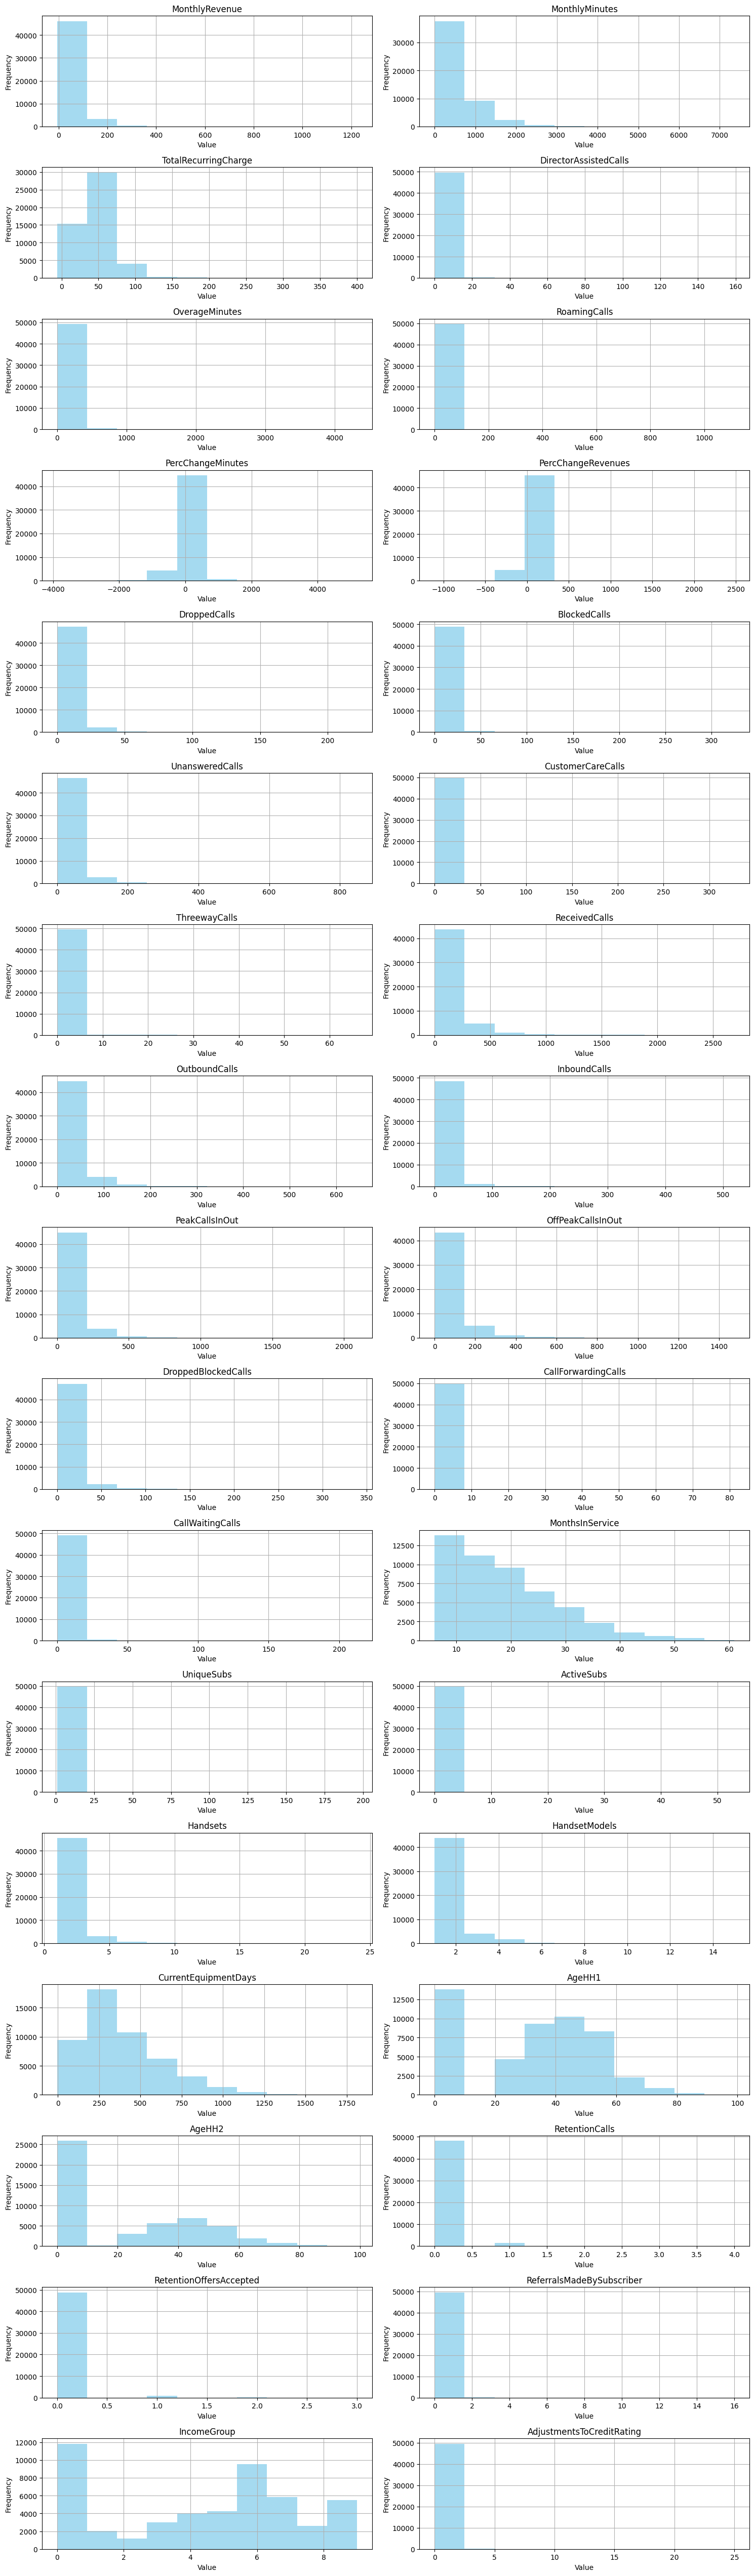

In [47]:
num_features = len(numerical_columns.columns)
num_rows = (num_features +1)//2
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3*num_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_columns.columns):
    ax = axes[i]
    ax.hist(numerical_columns[col], bins=10, alpha=0.75, color='skyblue')
    ax.set_title(col)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.grid(True)


fig.tight_layout()

plt.show()

In [131]:
numerical_columns.columns

Index(['MonthlyRevenue', 'MonthlyMinutes', 'TotalRecurringCharge',
       'DirectorAssistedCalls', 'OverageMinutes', 'RoamingCalls',
       'PercChangeMinutes', 'PercChangeRevenues', 'DroppedCalls',
       'BlockedCalls', 'UnansweredCalls', 'CustomerCareCalls', 'ThreewayCalls',
       'ReceivedCalls', 'OutboundCalls', 'InboundCalls', 'PeakCallsInOut',
       'OffPeakCallsInOut', 'DroppedBlockedCalls', 'CallForwardingCalls',
       'CallWaitingCalls', 'MonthsInService', 'UniqueSubs', 'ActiveSubs',
       'Handsets', 'HandsetModels', 'CurrentEquipmentDays', 'AgeHH1', 'AgeHH2',
       'RetentionCalls', 'RetentionOffersAccepted',
       'ReferralsMadeBySubscriber', 'IncomeGroup',
       'AdjustmentsToCreditRating'],
      dtype='object')

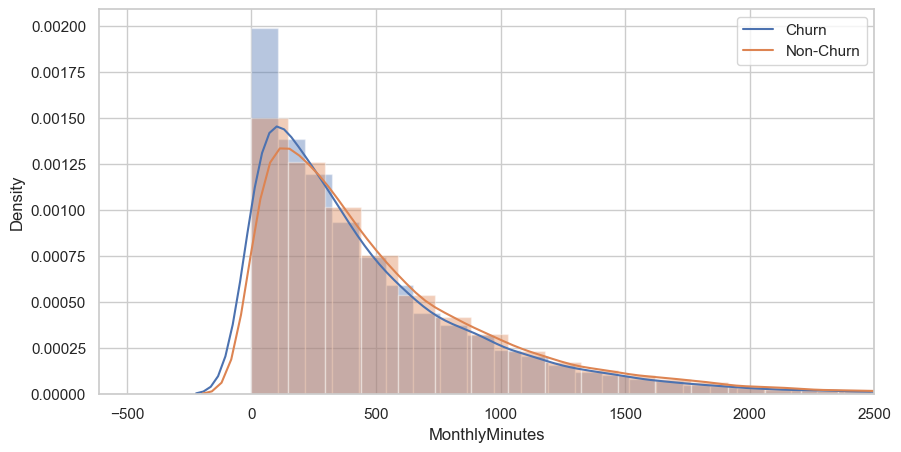

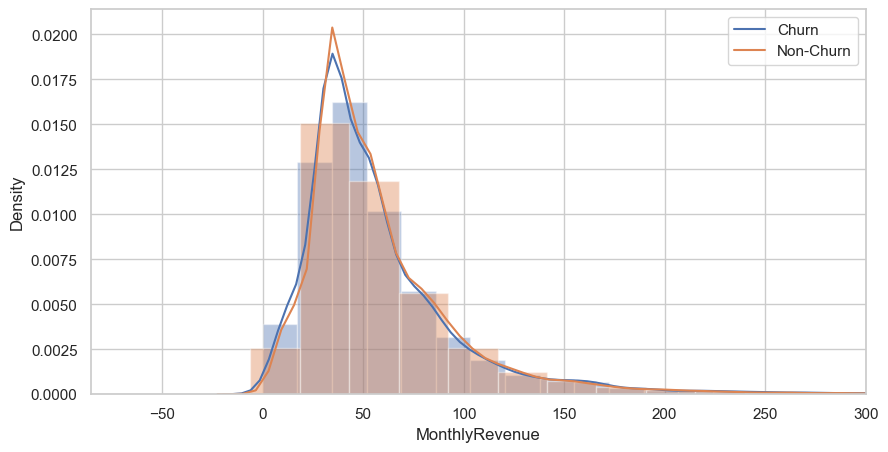

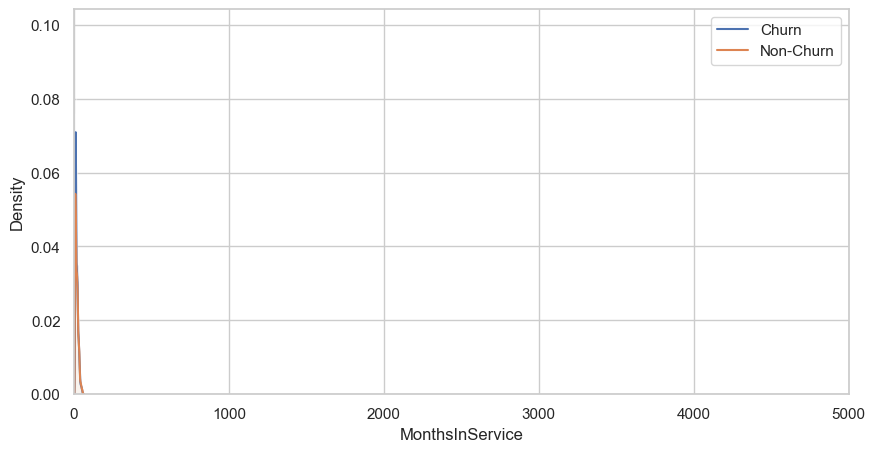

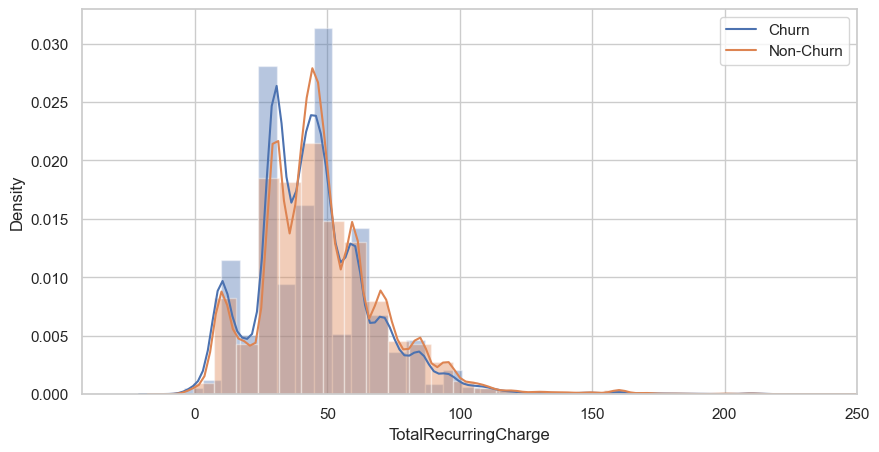

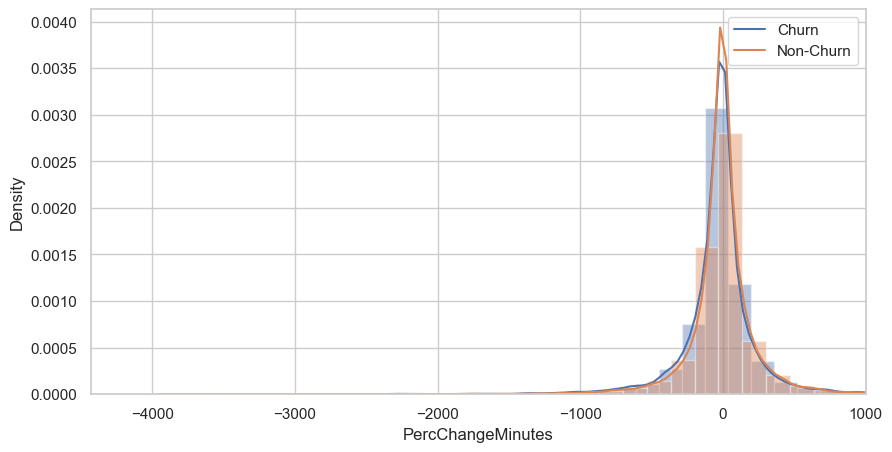

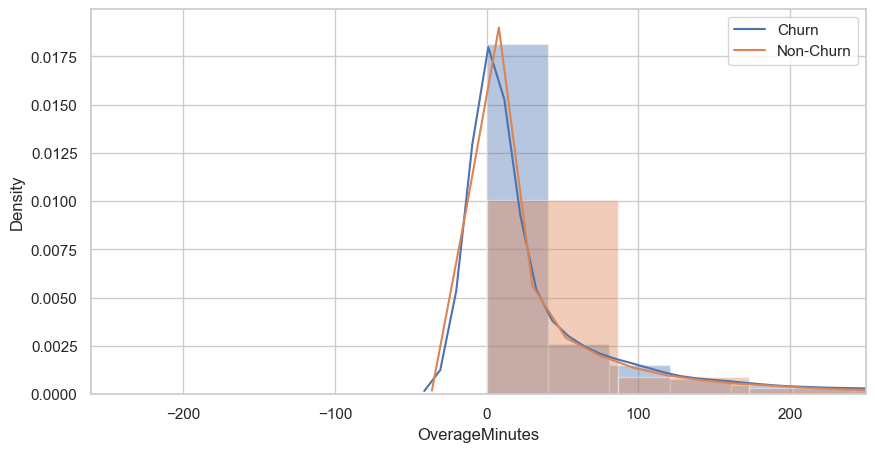

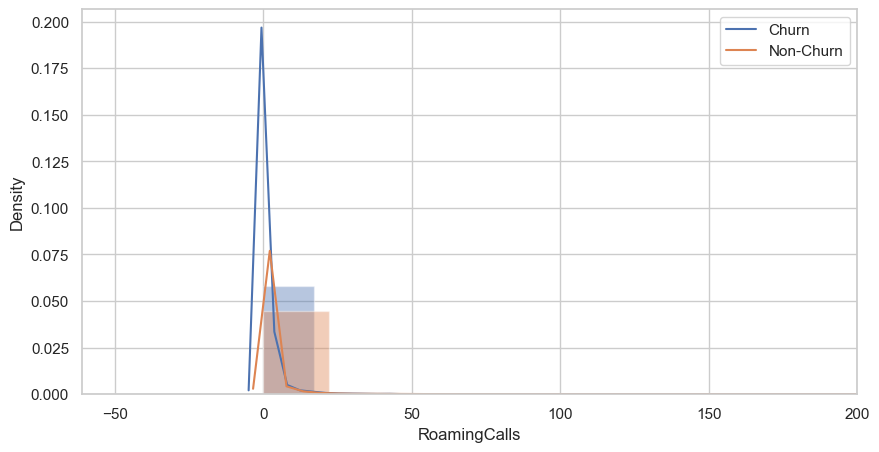

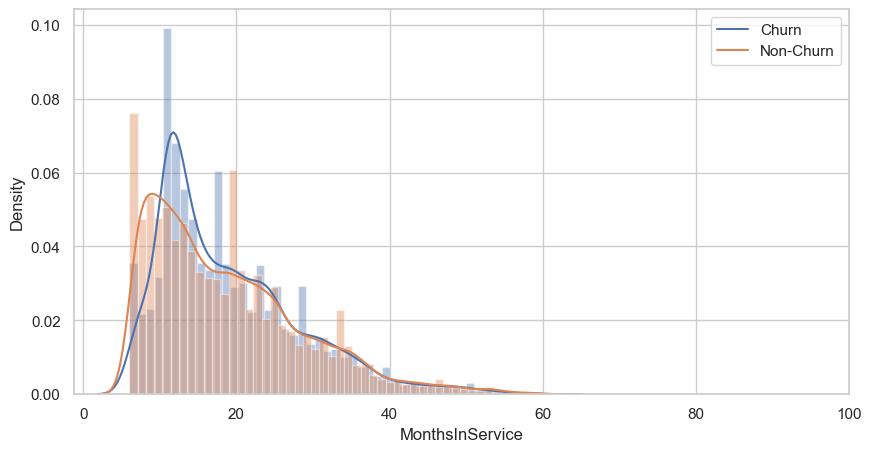

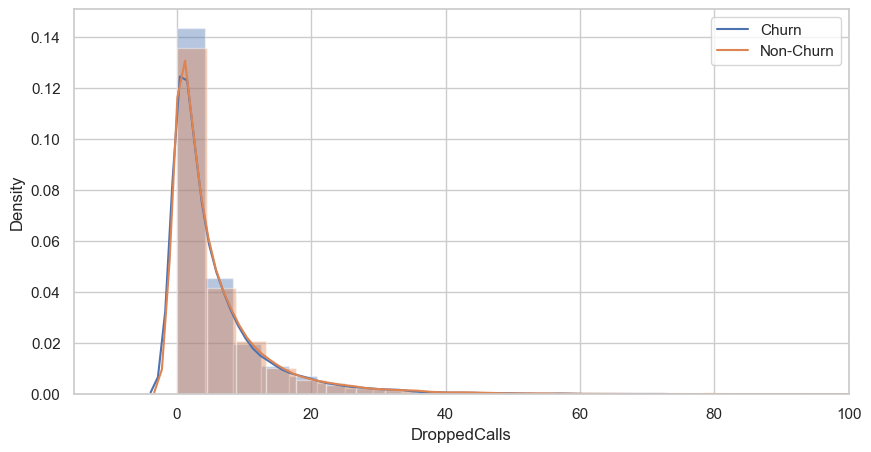

In [364]:
plot_distro(df, col='MonthlyMinutes', x_limit_r=2500, x_limit_l=0)
plot_distro(df, col='MonthlyRevenue', x_limit_r=300, x_limit_l=0)
plot_distro(df, col='MonthsInService', x_limit_r=5000, x_limit_l=0)
plot_distro(df, col='TotalRecurringCharge', x_limit_r=250, x_limit_l=0)
plot_distro(df, col='PercChangeMinutes', x_limit_r=1000, x_limit_l=0)
plot_distro(df, col='DirectorAssistedCalls', x_limit_r=20, x_limit_l=0)
plot_distro(df, col='OverageMinutes', x_limit_r=250, x_limit_l=0)
plot_distro(df, col='RoamingCalls', x_limit_r=200, x_limit_l=0)
plot_distro(df, col='IncomeGroup', x_limit_r=10, x_limit_l=0)
plot_distro(df, col='AgeHH1', x_limit_r=125, x_limit_l=0)
plot_distro(df, col='MonthsInService', x_limit_r=100, x_limit_l=0)
plot_distro(df, col='DroppedCalls', x_limit_r=100, x_limit_l=0)

warnings.filterwarnings('ignore')

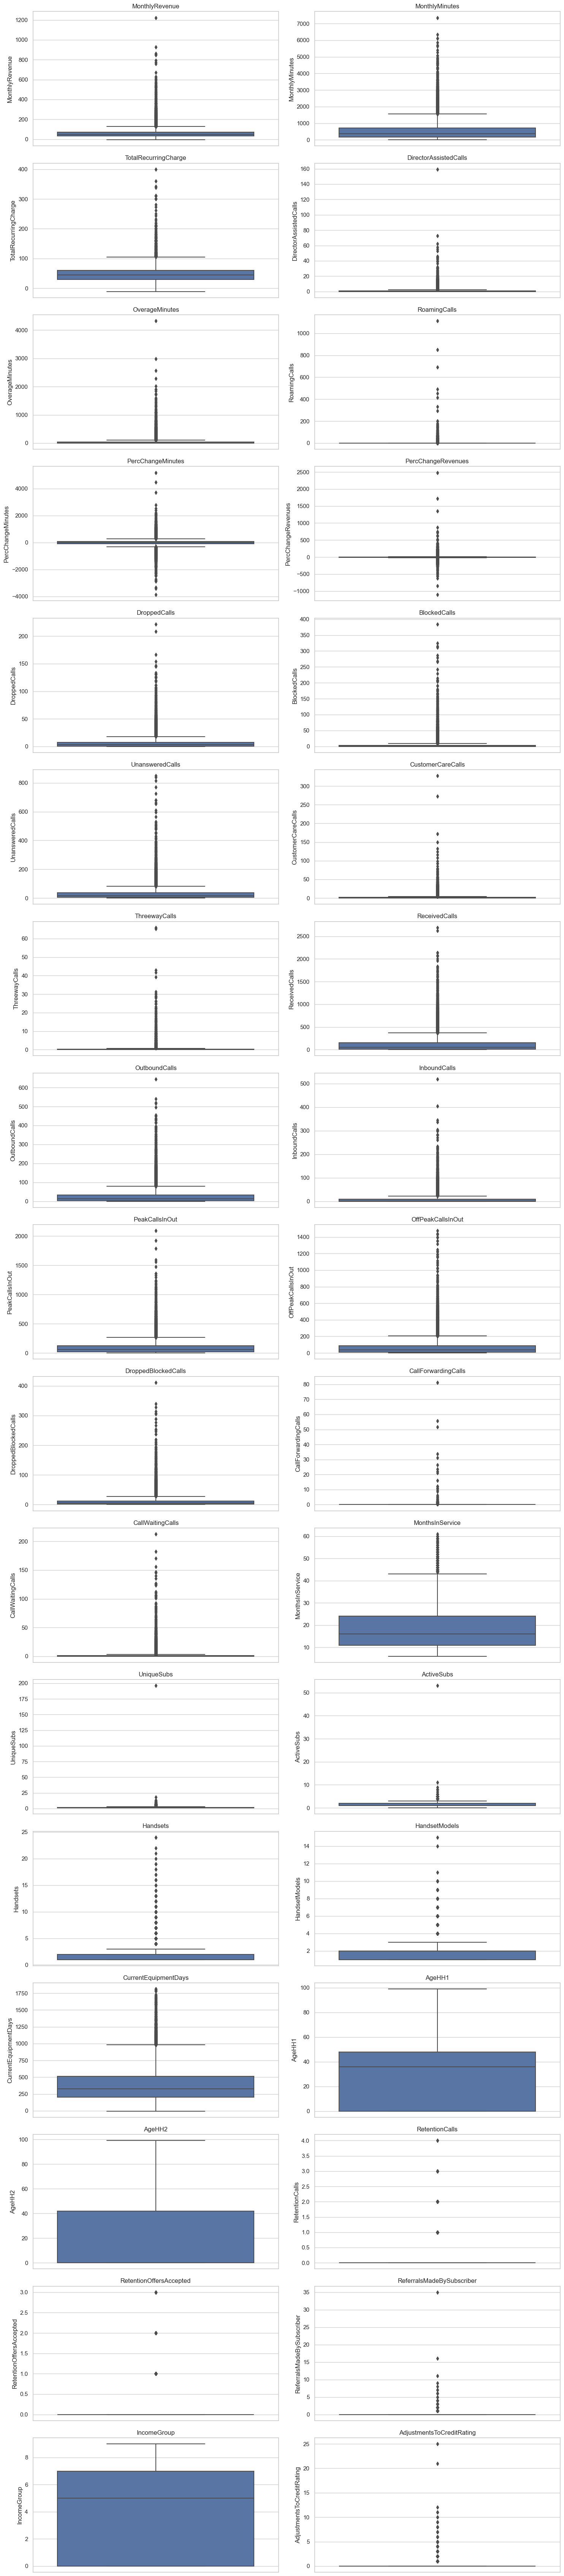

In [365]:
features = df.columns[df.columns.isin(numerical_columns)]
num_features = len(features)
num_cols = 2
num_rows = (num_features + num_cols - 1) // num_cols  # Round up division

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 4*num_rows))

axs = axs.flatten() if num_rows > 1 else [axs]

for i, feature in enumerate(features):
    ax = axs[i]
    sns.boxplot(y=feature, data=df, ax=ax)
    ax.set_title(feature)

    
plt.tight_layout()
plt.show()

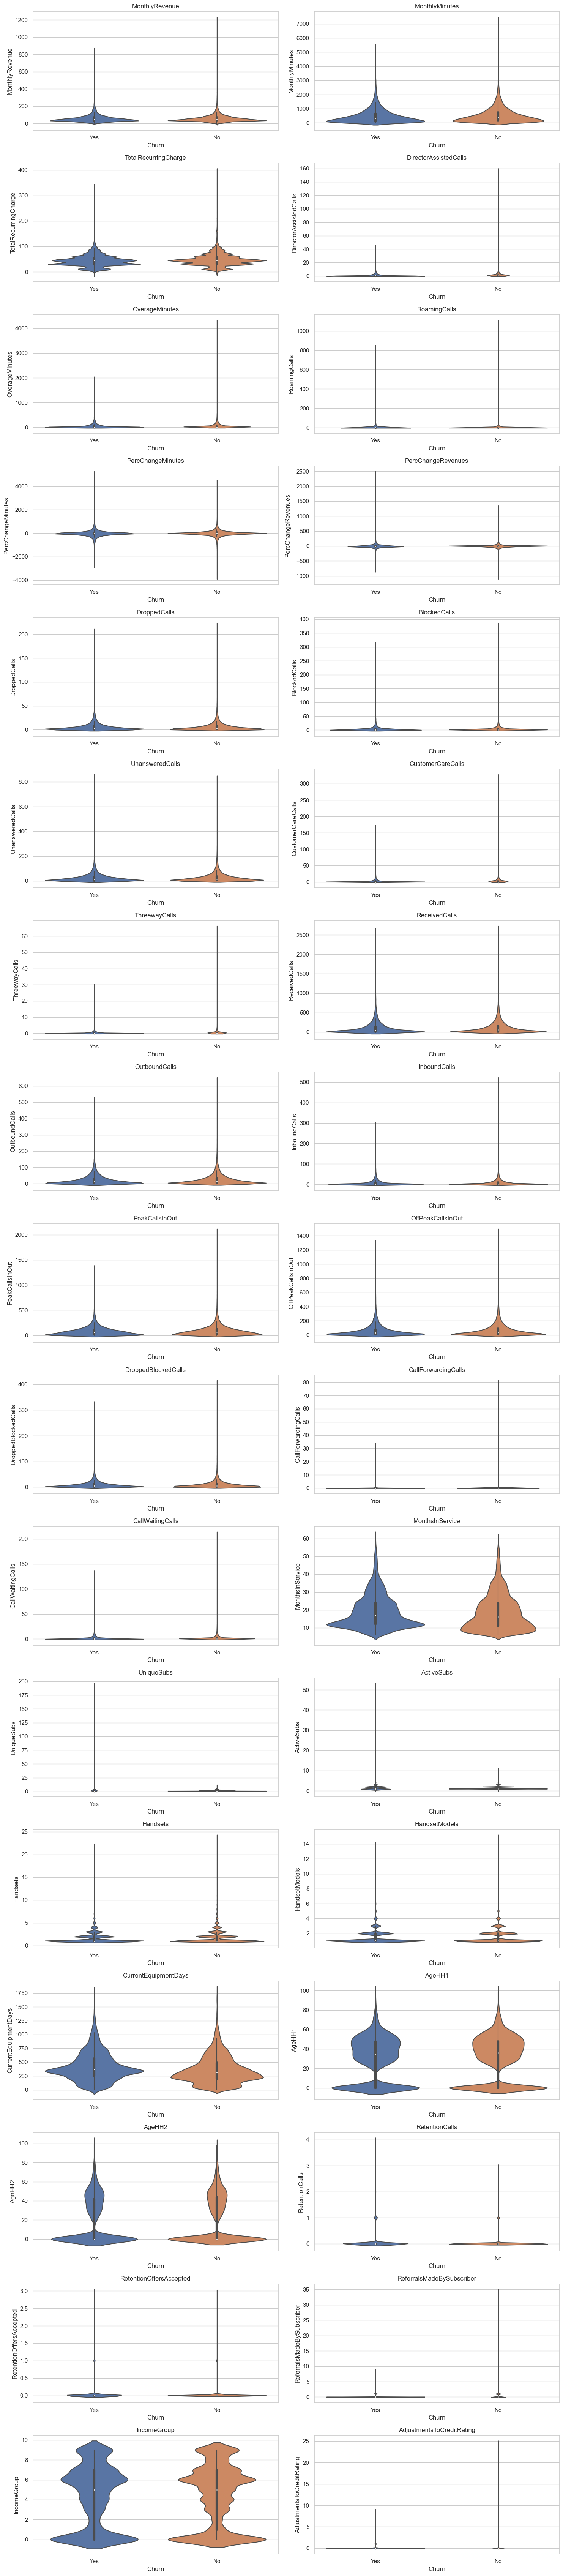

In [145]:
features = df.columns[df.columns.isin(numerical_columns)]
num_features = len(features)
num_cols = 2
num_rows = (num_features + num_cols - 1) // num_cols

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 4*num_rows))

for i, feature in enumerate(features):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]
    sns.violinplot(x='Churn', y=feature, data=df, ax=ax)
    ax.set_title(feature)

plt.tight_layout()
plt.show()

### 2. Categories visualization


**Barplots** for categorical columns

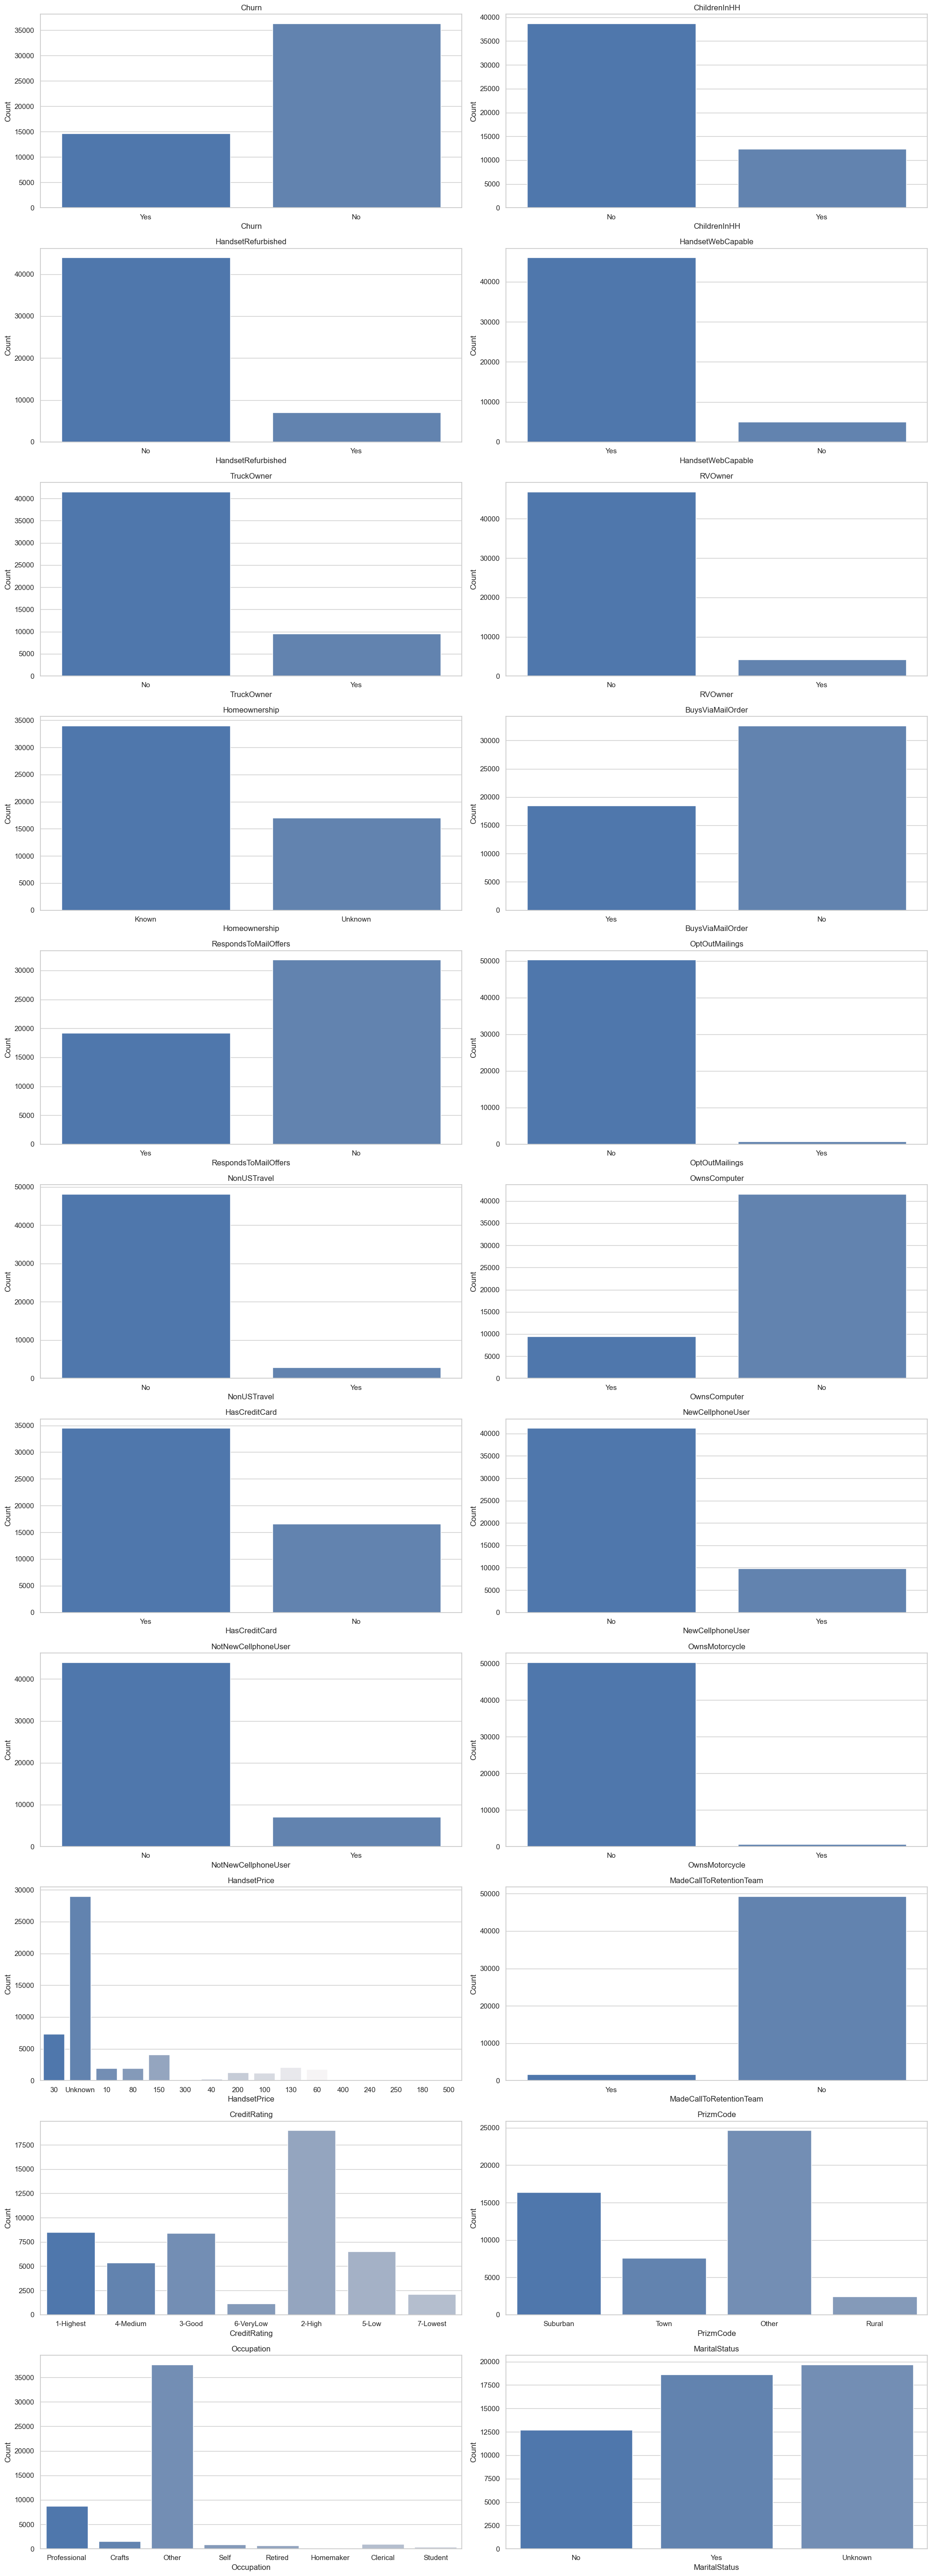

In [386]:
categorical_features = df.select_dtypes(include=['object']).columns.drop("ServiceArea")
num_features = len(categorical_features)
num_columns = 2
num_rows = (num_features + num_columns - 1) // num_columns

palette = sns.color_palette("vlag", len(categorical_features))

fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 5 * num_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    sns.countplot(x=col, data=df, ax=axes[i],palette= palette)
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

for j in range(i + 1, num_rows * num_columns):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Side-by-side churn and non-churn pie-chart and barplots against categories percentage distributions



In [47]:
df['AgeGroup1'] = pd.cut(
    df['AgeHH1'],
    bins=[-np.inf, 17, 25, 35, 45, 55, np.inf],
    labels=["17 and under", "18-25", "26-35", "36-45", "46-55", "56+"],
)
df['AgeGroup2'] = pd.cut(
    df['AgeHH2'],
    bins=[-np.inf, 17, 25, 35, 45, 55, np.inf],
    labels=["17 and under", "18-25", "26-35", "36-45", "46-55", "56+"],
)

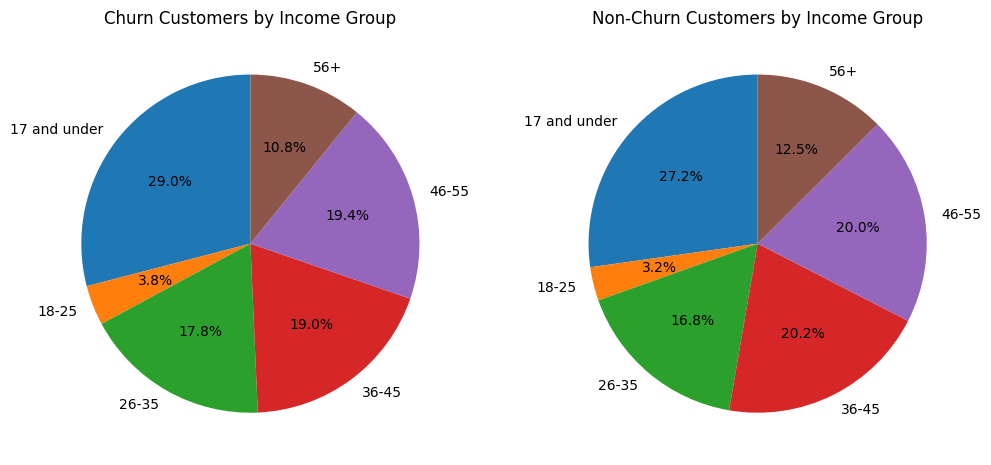

In [176]:
grouped = df.groupby(['AgeGroup1', 'Churn']).size().unstack(fill_value=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].pie(grouped['Yes'], labels=grouped.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Churn Customers by Income Group')

axes[1].pie(grouped['No'], labels=grouped.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Non-Churn Customers by Income Group')

plt.show()
warnings.filterwarnings('ignore')
distribution_categorical(df,"AgeGroup1",["17 and under", "18-25", "26-35", "36-45", "46-55", "56+"])


**Insight:** Customers younger than 36-45 group churn more.

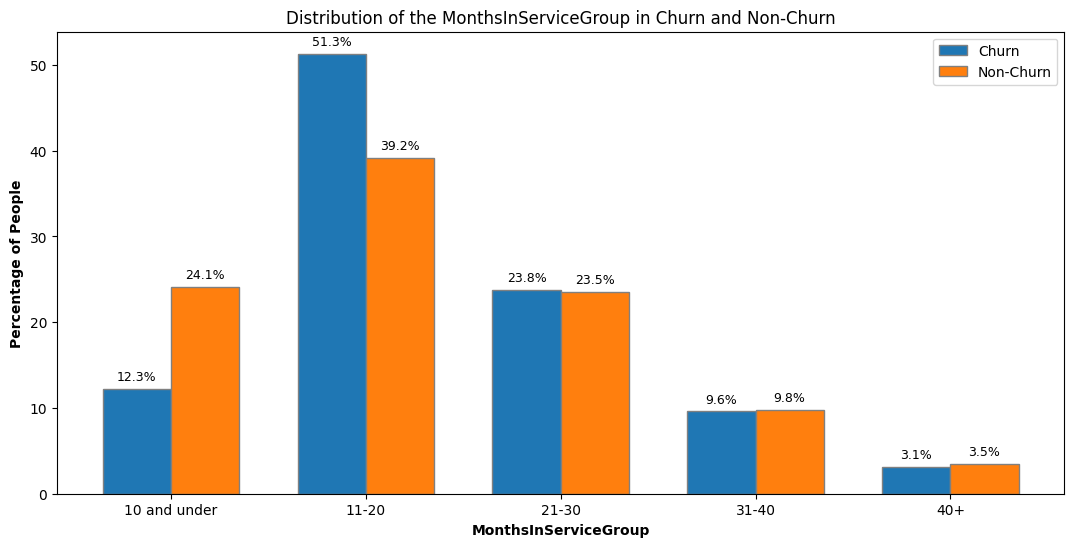

In [178]:
df['MonthsInServiceGroup'] = pd.cut(
    df['MonthsInService'],
    bins=[-np.inf, 10, 20, 30, 40, np.inf],
    labels=["10 and under", "11-20", "21-30", "31-40","40+"],
)
grouped = df.groupby(['MonthsInServiceGroup', 'Churn']).size().unstack(fill_value=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].pie(grouped['Yes'], labels=grouped.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Churn Customers by Income Group')

axes[1].pie(grouped['No'], labels=grouped.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Non-Churn Customers by Income Group')

plt.show()
warnings.filterwarnings('ignore')
distribution_categorical(df,"MonthsInServiceGroup",["10 and under", "11-20", "21-30", "31-40","40+"])

**Insight:** There might be less caring of people that have been with the company between 11 to 20 months

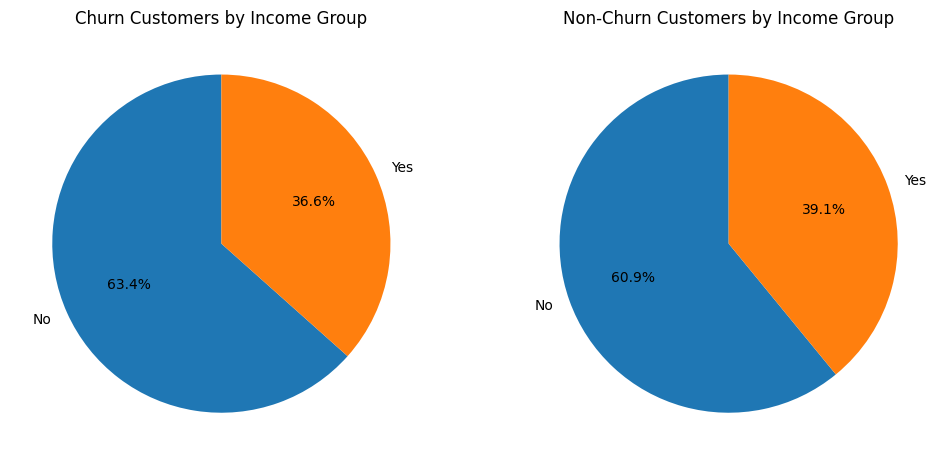

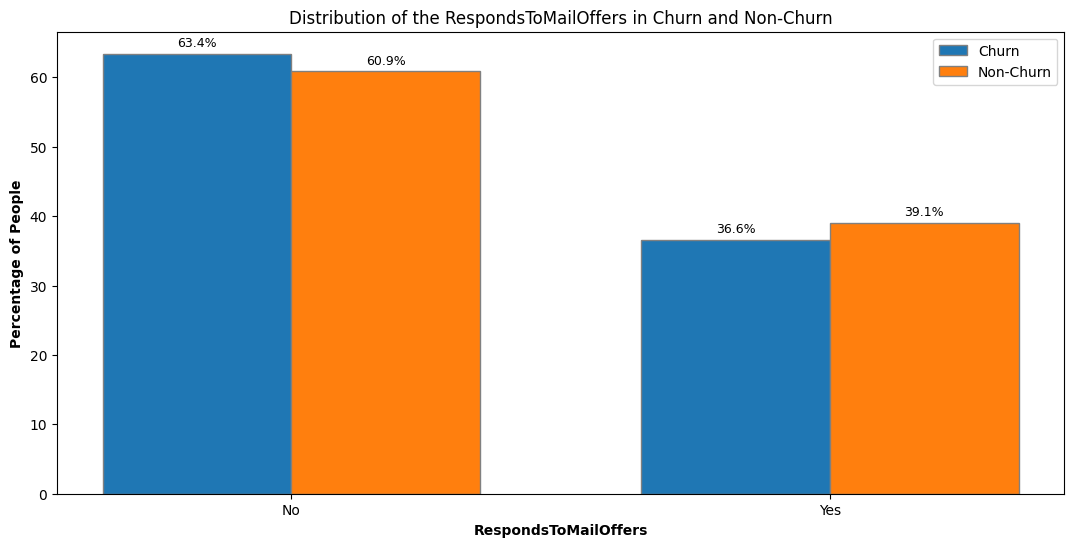

In [179]:
grouped = df.groupby(['RespondsToMailOffers', 'Churn']).size().unstack(fill_value=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].pie(grouped['Yes'], labels=grouped.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Churn Customers by Income Group')

axes[1].pie(grouped['No'], labels=grouped.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Non-Churn Customers by Income Group')

plt.show()
warnings.filterwarnings('ignore')
distribution_categorical(df,"RespondsToMailOffers")

**Insight:** we must know which customers didn't respond to mail offers to find another way to offer them

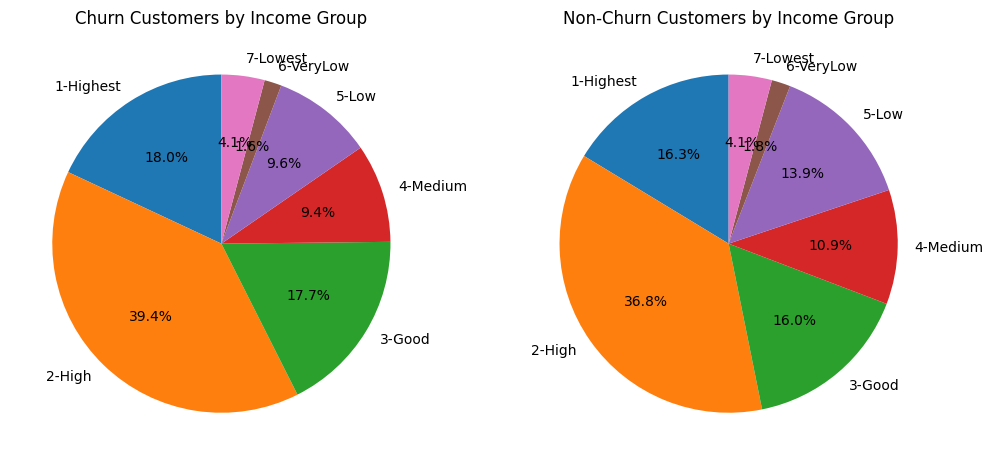

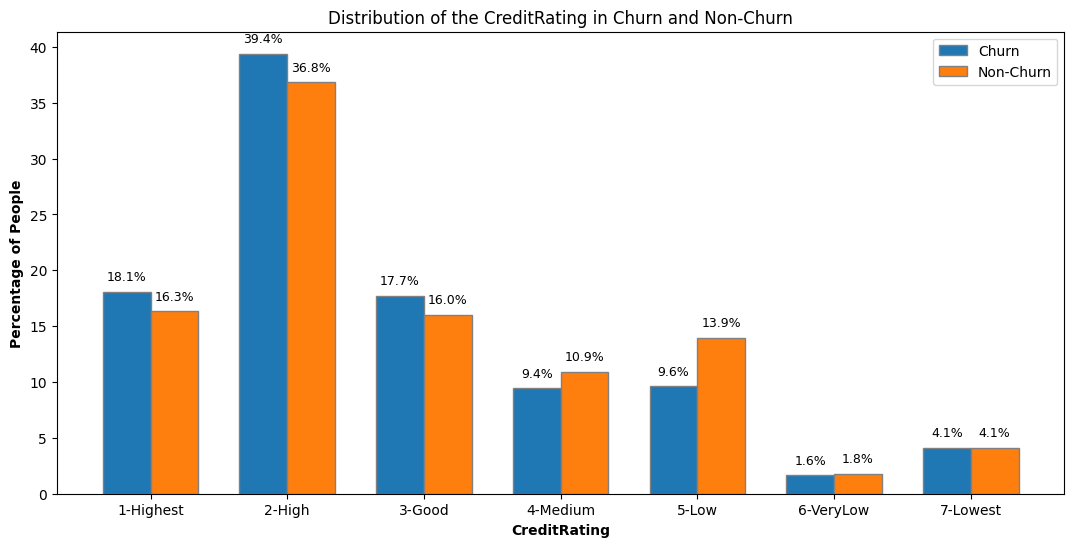

In [180]:
grouped = df.groupby(['CreditRating', 'Churn']).size().unstack(fill_value=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].pie(grouped['Yes'], labels=grouped.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Churn Customers by Income Group')

axes[1].pie(grouped['No'], labels=grouped.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Non-Churn Customers by Income Group')

plt.show()
warnings.filterwarnings('ignore')
distribution_categorical(df,"CreditRating")

**Insight:** Churn customers have a higher credit rating than non-churn customers; this may occur as: 
- Customers with a higher credit rating have access to more attractive offers from competitors as companies target those customers as low-risk customers.
- Higher credit rating Customers may have high expectations, so when they are dissatisfied, they might look for another company.

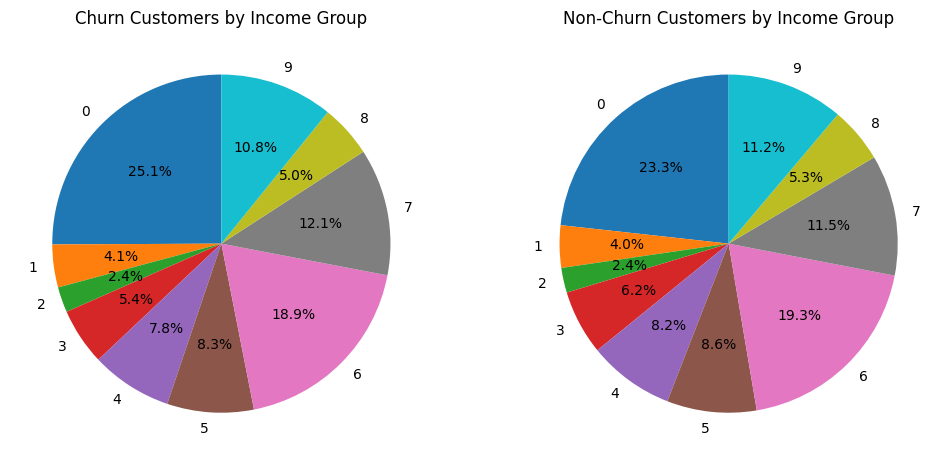

In [182]:
grouped = df.groupby(['IncomeGroup', 'Churn']).size().unstack(fill_value=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].pie(grouped['Yes'], labels=grouped.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Churn Customers by Income Group')

axes[1].pie(grouped['No'], labels=grouped.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Non-Churn Customers by Income Group')

plt.show()
warnings.filterwarnings('ignore')

distribution_categorical(df,"IncomeGroup")

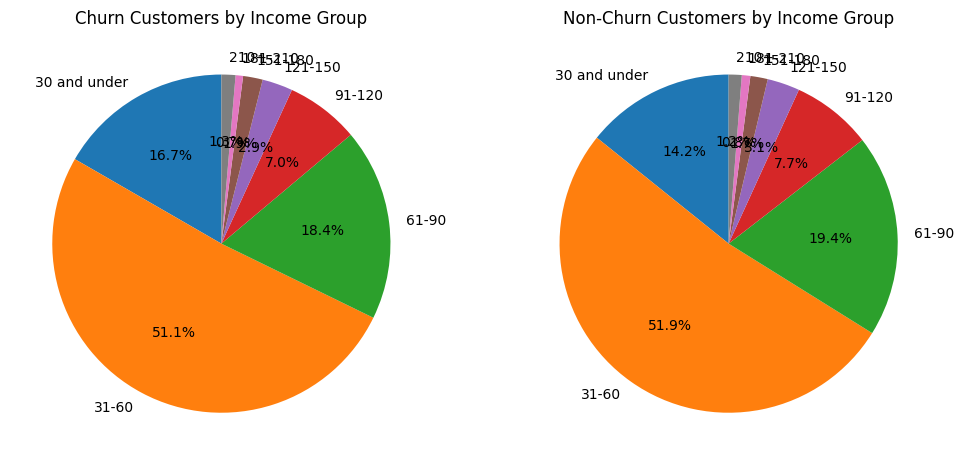

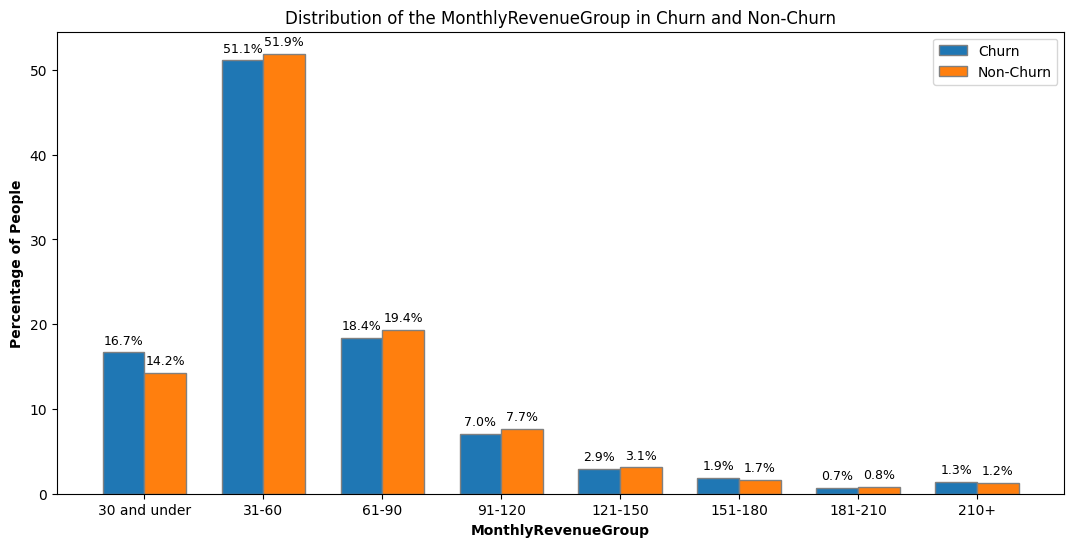

In [181]:
df['MonthlyRevenueGroup'] = pd.cut(
    df['MonthlyRevenue'],
    bins=[-np.inf, 30, 60, 90, 120, 150,180,210, np.inf],
    labels=["30 and under", "31-60", "61-90", "91-120", "121-150", "151-180","181-210","210+"],
)
grouped = df.groupby(['MonthlyRevenueGroup', 'Churn']).size().unstack(fill_value=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].pie(grouped['Yes'], labels=grouped.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Churn Customers by Income Group')

axes[1].pie(grouped['No'], labels=grouped.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Non-Churn Customers by Income Group')

plt.show()
warnings.filterwarnings('ignore')
distribution_categorical(df,"MonthlyRevenueGroup",["30 and under", "31-60", "61-90", "91-120", "121-150", "151-180","181-210","210+"])

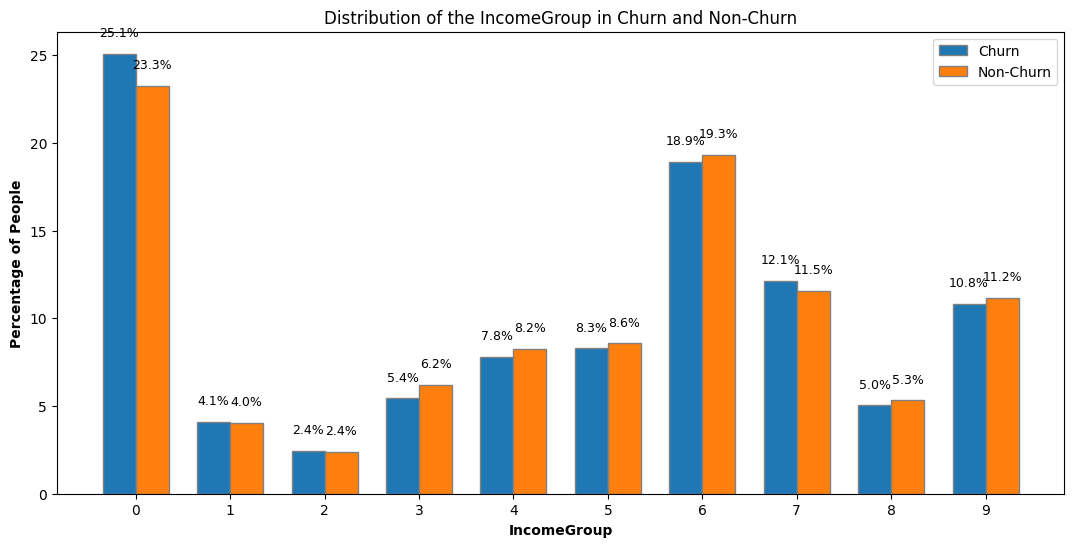

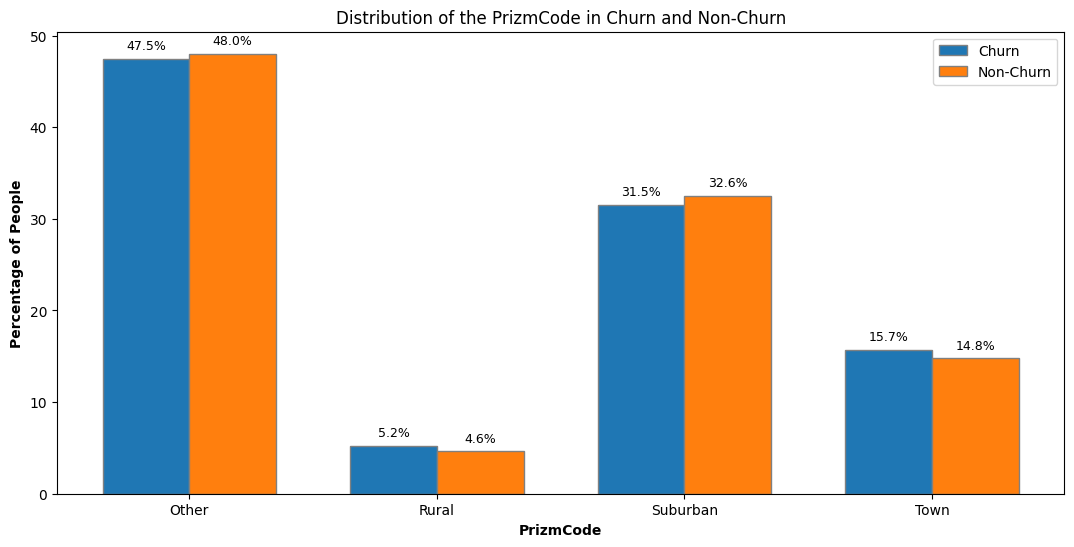

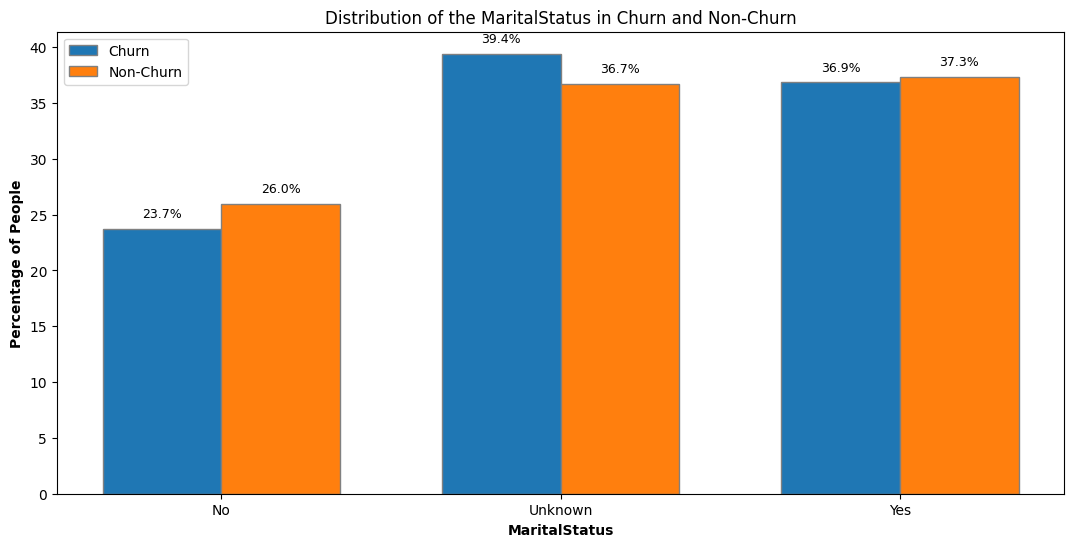

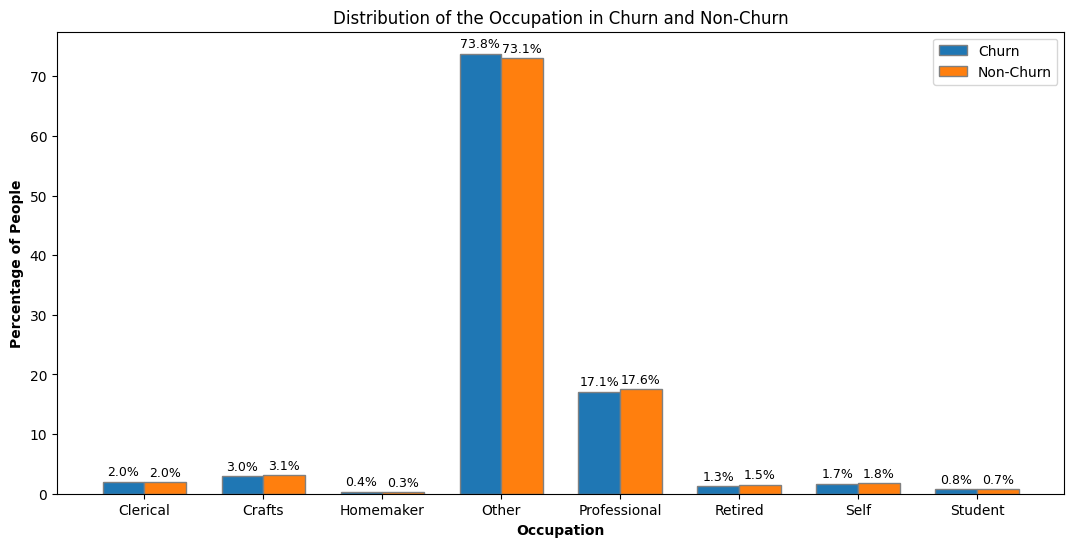

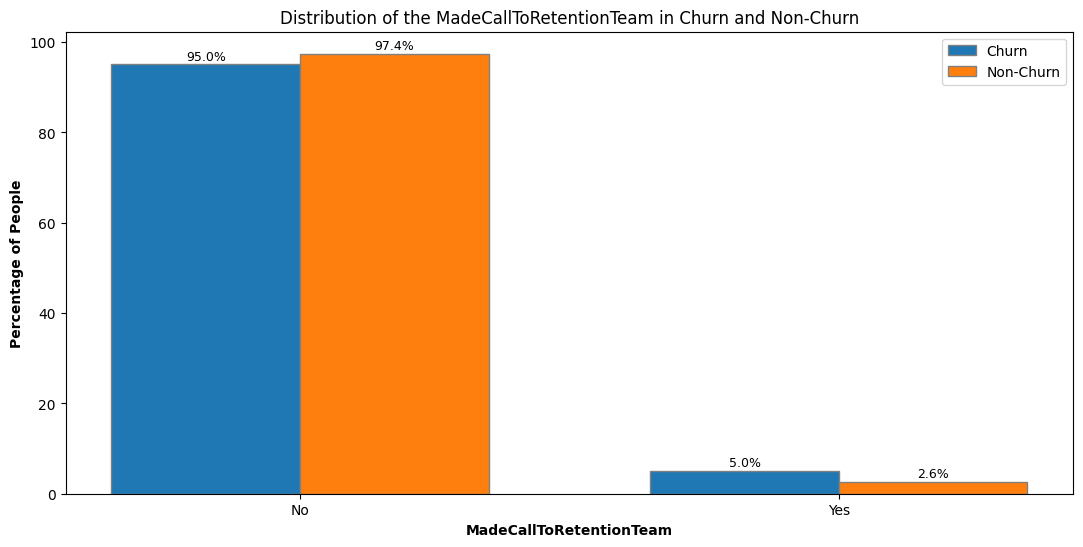

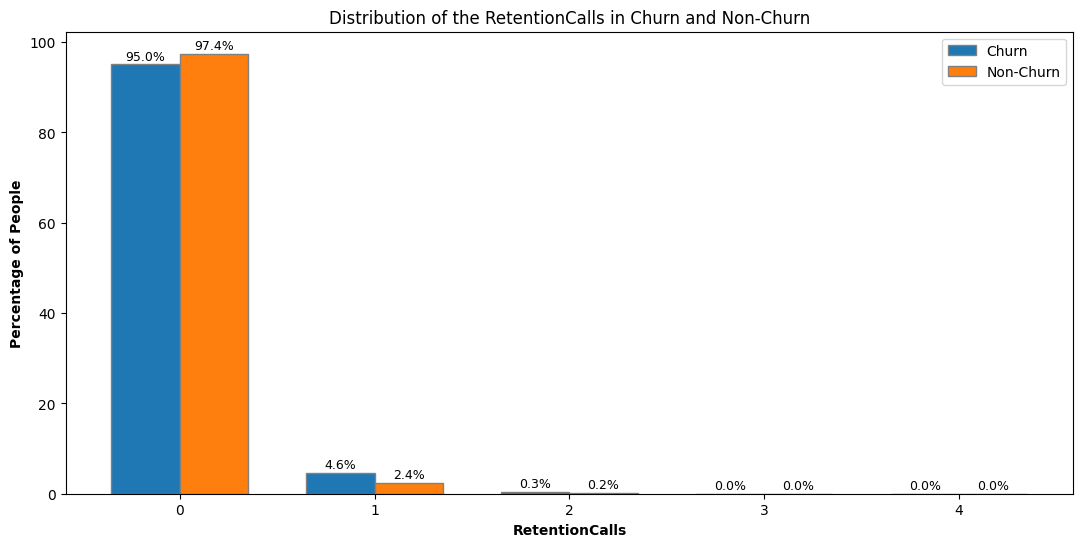

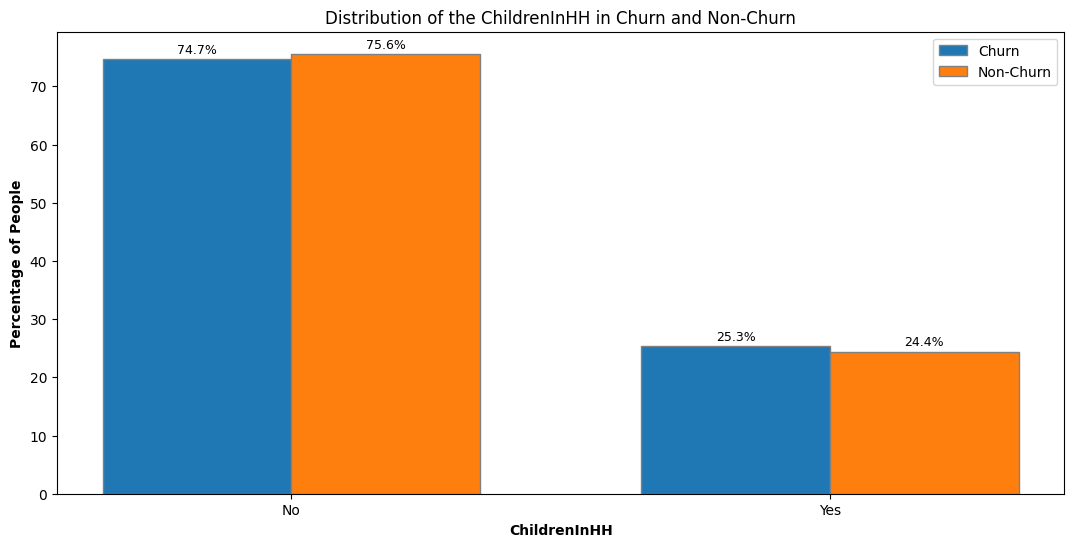

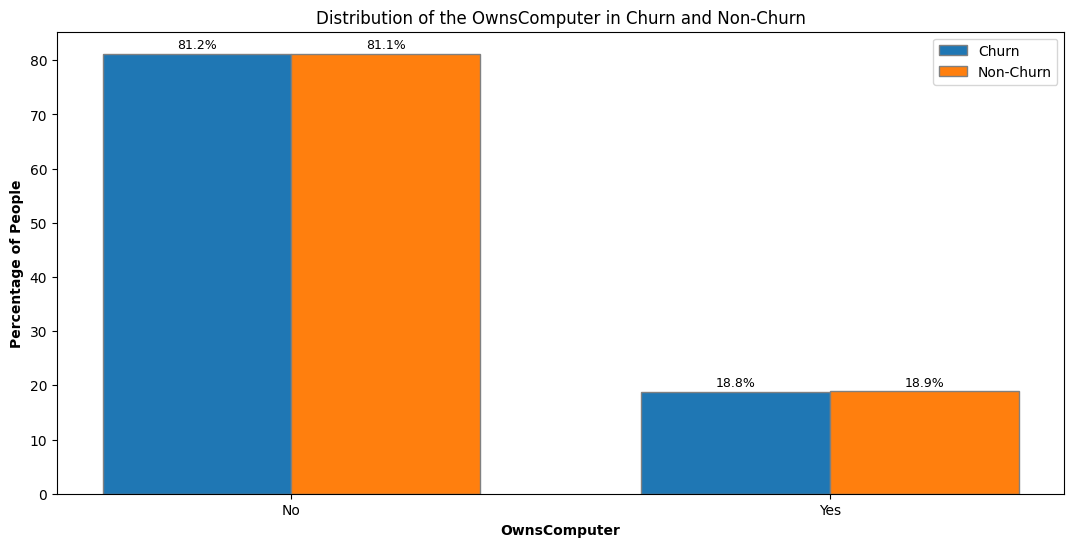

In [21]:
distribution_categorical(df,"PrizmCode")
distribution_categorical(df,"MaritalStatus")
distribution_categorical(df,"Occupation")
distribution_categorical(df,"MadeCallToRetentionTeam")
distribution_categorical(df,"RetentionCalls",[0,1,2,3,4])
distribution_categorical(df,"ChildrenInHH")
distribution_categorical(df,"OwnsComputer")

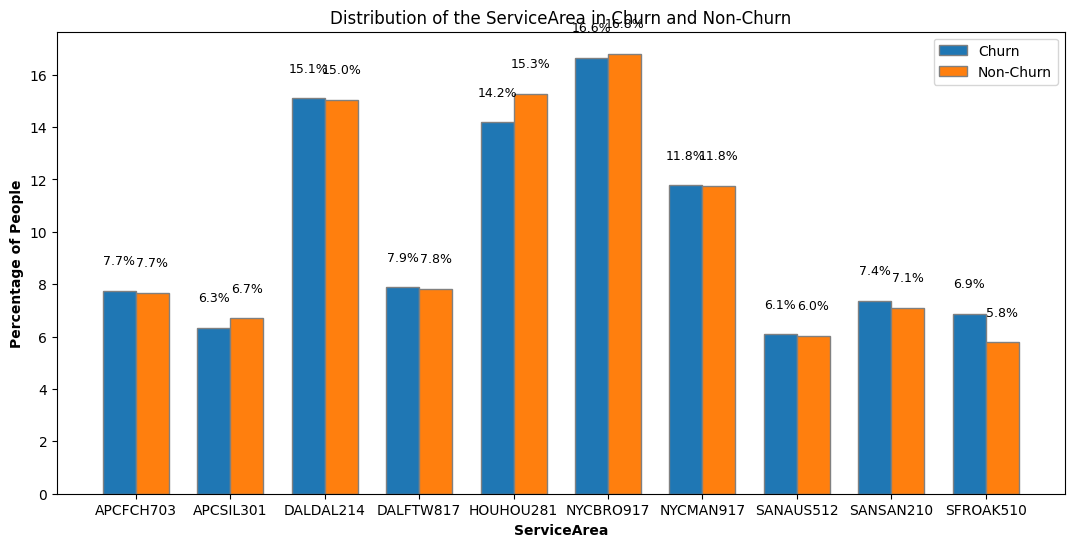

In [19]:
Top10_service_areas = df.groupby('ServiceArea').count().sort_values(by="Churn",ascending=False).reset_index().head(10)['ServiceArea']
df_top10_SA = df[df['ServiceArea'].isin(Top10_service_areas)]
distribution_categorical(df_top10_SA,"ServiceArea")

## Data  Pre-processing and Feature Engineering

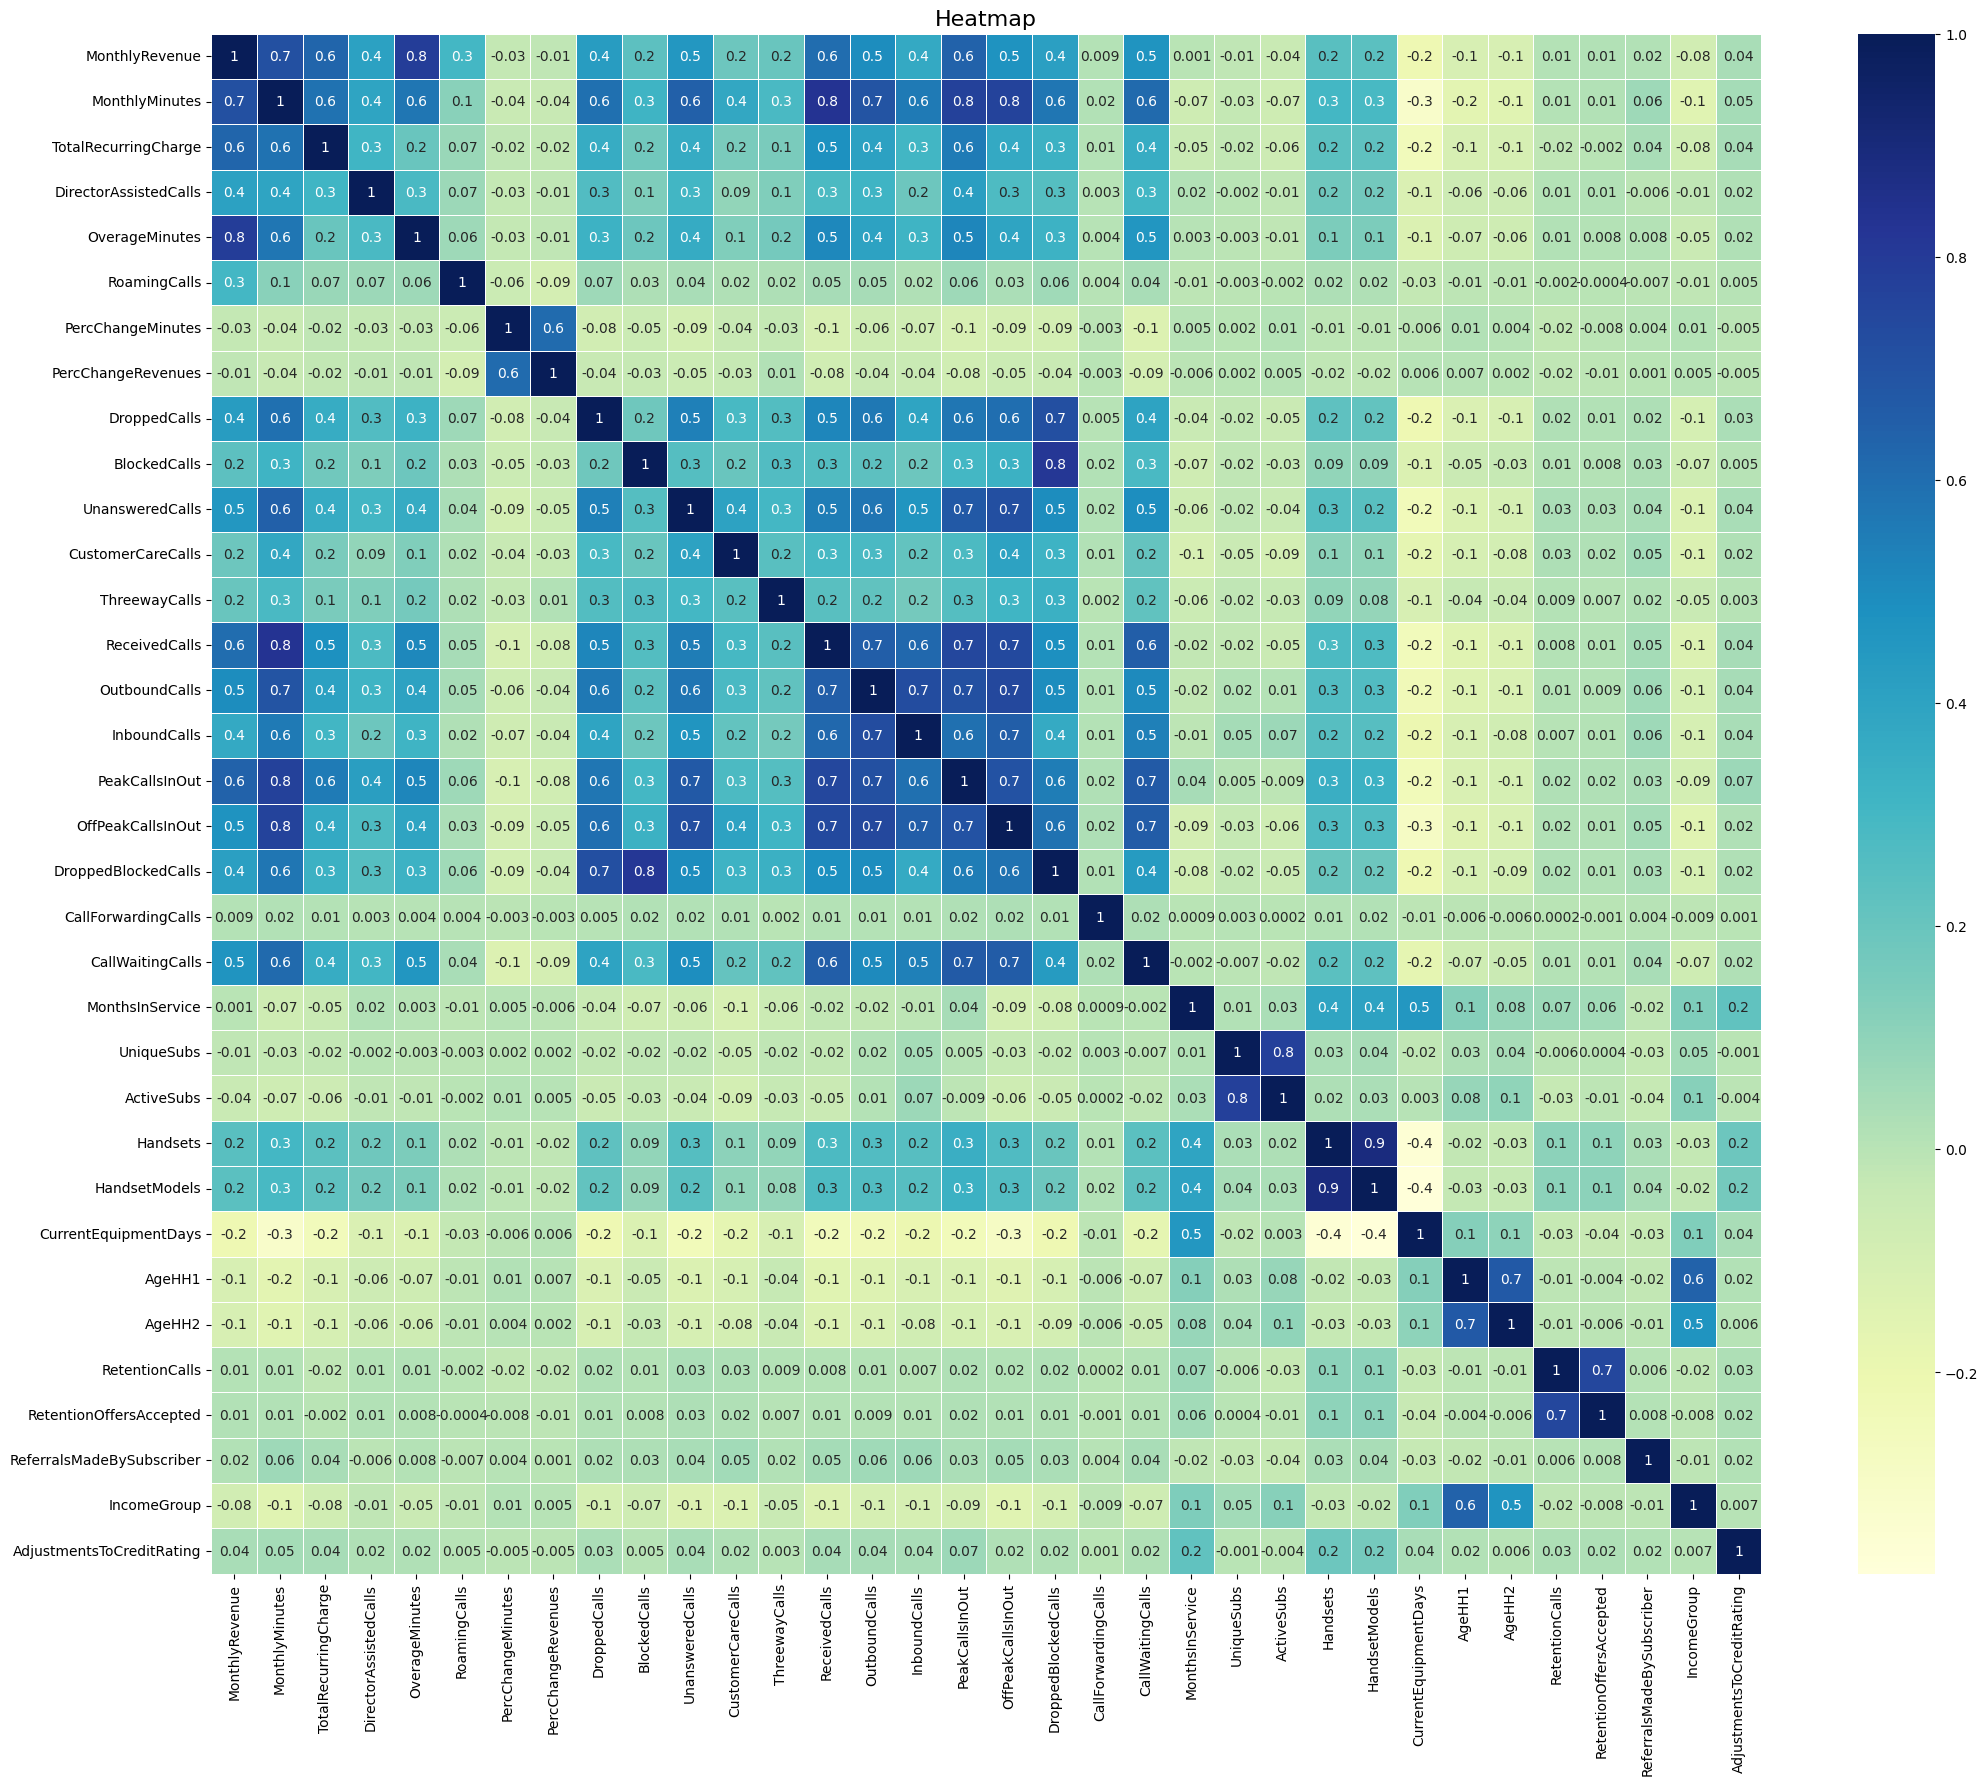

In [27]:
plt.rcParams["figure.figsize"] = (25,20)
sns.heatmap(numerical_columns[:].corr(),annot = True,fmt='.1g',linecolor='white',cmap="YlGnBu",linewidths=.5)
plt.title("Heatmap",fontsize= 16)
plt.show()

### Outliers handling:


In [18]:
outlier_counts_numeric = count_outliers_in_numerical_columns(df)
print("Outlier counts in numerical columns:")
display(outlier_counts_numeric)

Outlier counts in numerical columns:


{'MonthlyRevenue': 2912,
 'MonthlyMinutes': 2511,
 'TotalRecurringCharge': 796,
 'DirectorAssistedCalls': 5378,
 'OverageMinutes': 5803,
 'RoamingCalls': 8616,
 'PercChangeMinutes': 6678,
 'PercChangeRevenues': 13017,
 'DroppedCalls': 3617,
 'BlockedCalls': 5376,
 'UnansweredCalls': 3528,
 'CustomerCareCalls': 6571,
 'ThreewayCalls': 4491,
 'ReceivedCalls': 3547,
 'OutboundCalls': 3251,
 'InboundCalls': 4838,
 'PeakCallsInOut': 2760,
 'OffPeakCallsInOut': 3526,
 'DroppedBlockedCalls': 3912,
 'CallForwardingCalls': 226,
 'CallWaitingCalls': 7237,
 'MonthsInService': 1152,
 'UniqueSubs': 1787,
 'ActiveSubs': 561,
 'Handsets': 4298,
 'HandsetModels': 1960,
 'CurrentEquipmentDays': 1376,
 'AgeHH1': 0,
 'AgeHH2': 0,
 'RetentionCalls': 1621,
 'RetentionOffersAccepted': 860,
 'ReferralsMadeBySubscriber': 2326,
 'IncomeGroup': 0,
 'AdjustmentsToCreditRating': 1786}

In [48]:
df_replaced = replace_outliers_with_limits(df)
print("DataFrame with outliers replaced in numerical features only:")
display(df_replaced)


DataFrame with outliers replaced in numerical features only:


Churn  MonthlyRevenue  MonthlyMinutes  TotalRecurringCharge  \
0       Yes           24.00           219.0                  22.0   
1       Yes           16.99            10.0                  17.0   
2        No           38.00             8.0                  38.0   
3        No           82.28          1312.0                  75.0   
4       Yes           17.14             0.0                  17.0   
...     ...             ...             ...                   ...   
49747    No            0.00            76.0                  30.0   
49748    No           31.92            63.0                  17.0   
49749    No           71.99           724.0                  70.0   
49750   Yes          117.49           384.0                  30.0   
49751    No           95.17          1568.0                  85.0   

       DirectorAssistedCalls  OverageMinutes  RoamingCalls  PercChangeMinutes  \
0                       0.25             0.0           0.0             -157.0   
1                       0.00             0.0           0.0               -4.0   
2                       0.00             0.0           0.0               -2.0   
3                       1.24             0.0           0.0              157.0   
4                       0.00             0.0           0.0                0.0   
...                      ...             ...           ...                ...   
49747                   0.00             0.0           0.0                0.0   
49748                   0.00            43.0           0.0              -38.0   
49749                   0.00             4.0           0.7              -40.0   
49750                   0.00           100.0           0.0                0.0   
49751                   0.99            45.0           0.7              122.0   

       PercChangeRevenues  DroppedCalls  ...  OwnsMotorcycle  \
0                   -19.0           0.7  ...              No   
1                     0.0           0.3  ...              No   
2                     0.0           0.0  ...              No   
3                     8.1          18.0  ...              No   
4                    -0.2           0.0  ...              No   
...                   ...           ...  ...             ...   
49747                 0.0           5.7  ...              No   
49748               -13.2           0.7  ...              No   
49749                -2.0          14.3  ...              No   
49750                 0.0           4.0  ...              No   
49751                14.4          16.7  ...              No   

       AdjustmentsToCreditRating  HandsetPrice  MadeCallToRetentionTeam  \
0                              0            30                      Yes   
1                              0            30                       No   
2                              0       Unknown                       No   
3                              0            10                       No   
4                              0            10                       No   
...                          ...           ...                      ...   
49747                          0       Unknown                       No   
49748                          0       Unknown                       No   
49749                          0       Unknown                       No   
49750                          0            30                       No   
49751                          0            60                       No   

       CreditRating  PrizmCode    Occupation  MaritalStatus  AgeGroup1  \
0         1-Highest   Suburban  Professional             No        56+   
1          4-Medium   Suburban  Professional            Yes      36-45   
2            3-Good       Town        Crafts            Yes      26-35   
3          4-Medium      Other         Other             No      26-35   
4         1-Highest      Other  Professional            Yes      46-55   
...             ...        ...           ...            ...        ...   
49747        2-H

In [20]:
outlier_counts_numeric = count_outliers_in_numerical_columns(df_replaced)
print("Outlier counts in numerical columns:")
print(outlier_counts_numeric)

Outlier counts in numerical columns:
{'MonthlyRevenue': 0, 'MonthlyMinutes': 0, 'TotalRecurringCharge': 0, 'DirectorAssistedCalls': 0, 'OverageMinutes': 0, 'RoamingCalls': 0, 'PercChangeMinutes': 0, 'PercChangeRevenues': 0, 'DroppedCalls': 0, 'BlockedCalls': 0, 'UnansweredCalls': 0, 'CustomerCareCalls': 0, 'ThreewayCalls': 0, 'ReceivedCalls': 0, 'OutboundCalls': 0, 'InboundCalls': 0, 'PeakCallsInOut': 0, 'OffPeakCallsInOut': 0, 'DroppedBlockedCalls': 0, 'CallForwardingCalls': 0, 'CallWaitingCalls': 0, 'MonthsInService': 0, 'UniqueSubs': 0, 'ActiveSubs': 0, 'Handsets': 0, 'HandsetModels': 0, 'CurrentEquipmentDays': 0, 'AgeHH1': 0, 'AgeHH2': 0, 'RetentionCalls': 0, 'RetentionOffersAccepted': 0, 'ReferralsMadeBySubscriber': 0, 'IncomeGroup': 0, 'AdjustmentsToCreditRating': 0}


## Selected Features:

Here is the list of features that were used in training the model:

- ChildrenInHH
- HandsetRefurbished
- HandsetWebCapable
- RespondsToMailOffers
- NotNewCellphoneUser
- HandsetPrice
- MadeCallToRetentionTeam
- CreditRating
- PrizmCode
- MaritalStatus
- ServiceArea_TargetEncoded
- MonthlyMinutes
- TotalRecurringCharge
- DirectorAssistedCalls
- OverageMinutes
- RoamingCalls
- PercChangeMinutes
- PercChangeRevenues
- DroppedCalls
- BlockedCalls
- UnansweredCalls
- CustomerCareCalls
- ThreewayCalls
- OutboundCalls
- InboundCalls
- OffPeakCallsInOut
- MonthsInService
- UniqueSubs
- HandsetModels
- CurrentEquipmentDays
- age_group1
- age_group2
- ReferralsMadeBySubscriber
- IncomeGroup
- AdjustmentsToCreditRating
- CallForwardingCalls


In [112]:
df_final = df_replaced[["ChildrenInHH",
#                         ,"HandsetRefurbished",
#                         "HandsetWebCapable",
                        "RespondsToMailOffers"
#                         ,"NotNewCellphoneUser"
,"HandsetPrice","MadeCallToRetentionTeam","CreditRating","PrizmCode","MaritalStatus","ServiceArea"
,"MonthlyMinutes","TotalRecurringCharge","DirectorAssistedCalls","OverageMinutes","RoamingCalls","PercChangeMinutes"
,"PercChangeRevenues","DroppedCalls","BlockedCalls","UnansweredCalls","CustomerCareCalls","ThreewayCalls"
,"OutboundCalls","InboundCalls","OffPeakCallsInOut","MonthsInService","UniqueSubs"
#                         ,"HandsetModels"
# ,"CurrentEquipmentDays"
                        ,"AgeGroup1",
#"AgeGroup2",
"ReferralsMadeBySubscriber",
                        "IncomeGroup",
                        "AdjustmentsToCreditRating",
                        "CallForwardingCalls"]]

### Encoding Categorical Features

In [113]:
categorical_features = df_replaced.select_dtypes(include=['object'])
display(categorical_features.head())

Churn ServiceArea ChildrenInHH HandsetRefurbished HandsetWebCapable  \
0   Yes   SEAPOR503           No                 No               Yes   
1   Yes   PITHOM412          Yes                 No                No   
2    No   MILMIL414          Yes                 No                No   
3    No   PITHOM412           No                 No               Yes   
4   Yes   OKCTUL918           No                 No                No   

  TruckOwner RVOwner Homeownership BuysViaMailOrder RespondsToMailOffers  ...  \
0         No      No         Known              Yes                  Yes  ...   
1         No      No         Known              Yes                  Yes  ...   
2         No      No       Unknown               No                   No  ...   
3         No      No         Known              Yes                  Yes  ...   
4         No      No         Known              Yes                  Yes  ...   

  HasCreditCard NewCellphoneUser NotNewCellphoneUser OwnsMotorcycle  \
0           Yes               No                  No             No   
1           Yes              Yes                  No             No   
2           Yes              Yes                  No             No   
3           Yes              Yes                  No             No   
4           Yes               No                 Yes             No   

  HandsetPrice MadeCallToRetentionTeam CreditRating PrizmCode    Occupation  \
0           30                     Yes    1-Highest  Suburban  Professional   
1           30                      No     4-Medium  Suburban  Professional   
2      Unknown                      No       3-Good      Town        Crafts   
3           10                      No     4-Medium     Other         Other   
4           10                      No    1-Highest     Other  Professional   

  MaritalStatus  
0            No  
1           Yes  
2           Yes  
3            No  
4           Yes  

[5 rows x 23 columns]

In [84]:
for col in categorical_features:
    print(categorical_features[col].value_counts())

Churn

No     35507

Yes    14245

Name: count, dtype: int64

ServiceArea

NYCBRO917    1646

DALDAL214    1479

HOUHOU281    1471

NYCMAN917    1156

DALFTW817     771

             ... 

SANROM956       1

INDCRA765       1

SEWSUN509       1

ATLDBL478       1

NCRDNN910       1

Name: count, Length: 743, dtype: int64

ChildrenInHH

No     37483

Yes    12269

Name: count, dtype: int64

HandsetRefurbished

No     42852

Yes     6900

Name: count, dtype: int64

HandsetWebCapable

Yes    44905

No      4847

Name: count, dtype: int64

TruckOwner

No     40280

Yes     9472

Name: count, dtype: int64

RVOwner

No     45619

Yes     4133

Name: count, dtype: int64

Homeownership

Known      33725

Unknown    16027

Name: count, dtype: int64

BuysViaMailOrder

No     31432

Yes    18320

Name: count, dtype: int64

RespondsToMailOffers

No     30667

Yes    19085

Name: count, dtype: int64

OptOutMailings

No     49006

Yes      746

Name: count, dtype: int64

NonUSTravel

No     46896

Y

#### One-hot encoding 

In [114]:
nominal_columns = ['ServiceArea','ChildrenInHH','HandsetRefurbished',
                   'HandsetWebCapable','TruckOwner','RVOwner','Homeownership',
                   'BuysViaMailOrder','OptOutMailings','NonUSTravel','OwnsComputer',
                   'HasCreditCard','NewCellphoneUser','NotNewCellphoneUser','OwnsMotorcycle',
                   'MadeCallToRetentionTeam','MaritalStatus','Occupation','RespondsToMailOffers']

In [115]:
df_encoded = pd.get_dummies(df_replaced, columns=nominal_columns)

display(df_encoded.head())

Churn  MonthlyRevenue  MonthlyMinutes  TotalRecurringCharge  \
0   Yes           24.00           219.0                  22.0   
1   Yes           16.99            10.0                  17.0   
2    No           38.00             8.0                  38.0   
3    No           82.28          1312.0                  75.0   
4   Yes           17.14             0.0                  17.0   

   DirectorAssistedCalls  OverageMinutes  RoamingCalls  PercChangeMinutes  \
0                   0.25             0.0           0.0             -157.0   
1                   0.00             0.0           0.0               -4.0   
2                   0.00             0.0           0.0               -2.0   
3                   1.24             0.0           0.0              157.0   
4                   0.00             0.0           0.0                0.0   

   PercChangeRevenues  DroppedCalls  ...  Occupation_Clerical  \
0               -19.0           0.7  ...                False   
1                 0.0           0.3  ...                False   
2                 0.0           0.0  ...                False   
3                 8.1          18.0  ...                False   
4                -0.2           0.0  ...                False   

   Occupation_Crafts  Occupation_Homemaker  Occupation_Other  \
0              False                 False             False   
1              False                 False             False   
2               True                 False             False   
3              False                 False              True   
4              False                 False             False   

   Occupation_Professional  Occupation_Retired  Occupation_Self  \
0                     True               False            False   
1                     True               False            False   
2                    False               False            False   
3                    False               False            False   
4                     True               False            False   

   Occupation_Student  RespondsToMailOffers_No  RespondsToMailOffers_Yes  
0               False                    False                      True  
1               False                    False                      True  
2               False                     True                     False  
3               False                    False                      True  
4               False                    False                      True  

[5 rows x 826 columns]

#### Label encoding

In [116]:
df_encoded['Churn'] = df_encoded['Churn'].replace('Yes', 1).replace('No', 0)
df_encoded['Churn'].value_counts()

/tmp/ipykernel_33/3925368549.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_encoded['Churn'] = df_encoded['Churn'].replace('Yes', 1).replace('No', 0)


Churn
0    35507
1    14245
Name: count, dtype: int64

In [143]:
display(df_encoded['HandsetPrice'].value_counts())

HandsetPrice
Unknown    28263
30          7147
150         4024
130         2043
80          1901
10          1869
60          1730
200         1227
100         1209
40           240
400           45
250           20
300           12
180            9
500            7
240            6
Name: count, dtype: int64

In [117]:
df_encoded['HandsetPrice'] = df_encoded['HandsetPrice'].replace('Unknown', 0)
df_encoded['HandsetPrice'] = df_encoded['HandsetPrice'].astype(int)
display(df_encoded['HandsetPrice'].value_counts())
df_encoded['HandsetPrice'] = pd.cut(
    df_encoded['HandsetPrice'],
    bins=[-np.inf, 0,50, 100, 200, 300, np.inf],
    labels=["Unknown", "1-50", "51-100", "101-200", "201-300", "300+"]
)

HandsetPrice
0      28263
30      7147
150     4024
130     2043
80      1901
10      1869
60      1730
200     1227
100     1209
40       240
400       45
250       20
300       12
180        9
500        7
240        6
Name: count, dtype: int64

In [31]:
display(df_encoded['HandsetPrice'].value_counts())

HandsetPrice
Unknown    28263
1-50        9256
101-200     7303
51-100      4840
300+          52
201-300       38
Name: count, dtype: int64

In [118]:
df_encoded['HandsetPrice'] = df_encoded['HandsetPrice'].replace('Unknown', 0).replace('1-50', 1).replace('51-100', 2).replace('101-200', 3).replace('201-300', 4).replace('300+', 5).astype(int)

/tmp/ipykernel_33/3625969860.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_encoded['HandsetPrice'] = df_encoded['HandsetPrice'].replace('Unknown', 0).replace('1-50', 1).replace('51-100', 2).replace('101-200', 3).replace('201-300', 4).replace('300+', 5).astype(int)
/tmp/ipykernel_33/3625969860.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_encoded['HandsetPrice'] = df_encoded['HandsetPrice'].replace('Unknown', 0).replace('1-50', 1).replace('51-100', 2).replace('101-200', 3).replace('201-300', 4).replace('300+', 5).astype(int)
/tmp/

In [33]:
df_encoded['CreditRating'].value_counts()

CreditRating
2-High       18692
1-Highest     8368
3-Good        8221
5-Low         6320
4-Medium      5227
7-Lowest      2049
6-VeryLow      875
Name: count, dtype: int64

In [119]:
df_encoded['CreditRating'] = df_encoded['CreditRating'].replace('7-Lowest', 0).replace('6-VeryLow', 1).replace('5-Low', 2).replace('4-Medium', 3).replace('3-Good', 4).replace('2-High', 5).replace('1-Highest', 6).astype(int)

/tmp/ipykernel_33/4260085001.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_encoded['CreditRating'] = df_encoded['CreditRating'].replace('7-Lowest', 0).replace('6-VeryLow', 1).replace('5-Low', 2).replace('4-Medium', 3).replace('3-Good', 4).replace('2-High', 5).replace('1-Highest', 6).astype(int)


In [35]:
df_encoded['CreditRating'].value_counts()

CreditRating
5    18692
6     8368
4     8221
2     6320
3     5227
0     2049
1      875
Name: count, dtype: int64

In [36]:
df_encoded['PrizmCode'].value_counts()

PrizmCode
Other       23820
Suburban    16049
Town         7494
Rural        2389
Name: count, dtype: int64

In [120]:
df_encoded['PrizmCode'] = df_encoded['PrizmCode'].replace('Other', 0).replace('Rural', 1).replace('Suburban', 2).replace('Town', 3).astype(int)

/tmp/ipykernel_33/4152010646.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_encoded['PrizmCode'] = df_encoded['PrizmCode'].replace('Other', 0).replace('Rural', 1).replace('Suburban', 2).replace('Town', 3).astype(int)


In [121]:
df_encoded['AgeGroup1'] = df_encoded['AgeGroup1'].replace('17 and under', 1).replace('18-25', 2).replace('26-35', 3).replace('36-45', 4).replace('46-55', 5).replace('56+', 6).astype(int)
df_encoded['AgeGroup2'] = df_encoded['AgeGroup2'].replace('17 and under', 1).replace('18-25', 2).replace('26-35', 3).replace('36-45', 4).replace('46-55', 5).replace('56+', 6).astype(int)

/tmp/ipykernel_33/1334881628.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_encoded['AgeGroup1'] = df_encoded['AgeGroup1'].replace('17 and under', 1).replace('18-25', 2).replace('26-35', 3).replace('36-45', 4).replace('46-55', 5).replace('56+', 6).astype(int)
/tmp/ipykernel_33/1334881628.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_encoded['AgeGroup1'] = df_encoded['AgeGroup1'].replace('17 and under', 1).replace('18-25', 2).replace('26-35', 3).replace('36-45', 4).replace('46-55', 5).replace('56+', 6).astype(int)
/tmp/ipykernel_33

## Model Building and Evaluation

In [122]:
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print("Train set class distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest set class distribution:")
print(y_test.value_counts(normalize=True))

Train set class distribution:
Churn
0    0.713691
1    0.286309
Name: proportion, dtype: float64

Test set class distribution:
Churn
0    0.713654
1    0.286346
Name: proportion, dtype: float64


### XGBoost

In [154]:
import xgboost as xgb

scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])  # Adjust the values based on your preferences


# Set XGBoost parameters
params = {
#     'objective': 'binary:logistic',  # for binary classification
    'scale_pos_weight': scale_pos_weight,
    'eval_metric': 'logloss',
    'subsample': 0.7, 
    'n_estimators': 7, 
    'max_depth': 5, 
    'learning_rate': 0.2, 
    'gamma': 0, 
    'colsample_bytree': 0.9
    ,'seed':0
}
#'subsample': 0.7, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.9

In [155]:
model = xgb.XGBClassifier(**params)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=7,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [156]:
# Evaluate on the training set
y_train_pred = model.predict(X_train)
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Training Classification Report:\n", classification_report(y_train, y_train_pred))

# Evaluate on the test set
y_test_pred = model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))

Training Accuracy: 0.5826968356974674
Training Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.53      0.64     24855
           1       0.38      0.73      0.50      9971

    accuracy                           0.58     34826
   macro avg       0.60      0.63      0.57     34826
weighted avg       0.70      0.58      0.60     34826

Test Accuracy: 0.5661262226986467
Test Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.51      0.63     10652
           1       0.37      0.71      0.48      4274

    accuracy                           0.57     14926
   macro avg       0.59      0.61      0.55     14926
weighted avg       0.68      0.57      0.59     14926



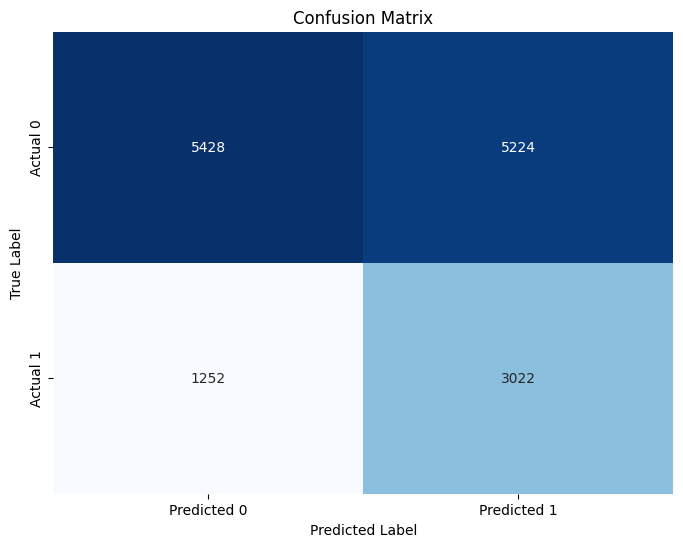

In [169]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

test_class_count = pd.DataFrame(y_test).value_counts()


cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [162]:
y_test_pred_proba = model.predict_proba(X_test)[::,1]

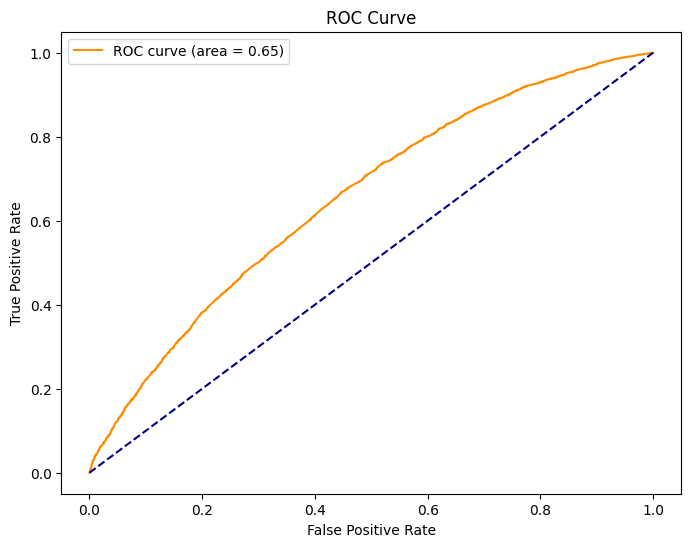

In [163]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_test_pred_proba)
roc_auc = metrics.auc(fpr, tpr)
 
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [164]:
# Get booster (underlying XGB model)
booster = model.get_booster()

# Retrieve feature importance
feature_importance = booster.get_score(importance_type='weight')  # Can also use 'gain', 'cover', 'total_gain', 'total_cover'

In [168]:
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

features = [x[0] for x in sorted_importance]
importance_values = [x[1] for x in sorted_importance]

# Create horizontal bar plot
plt.figure(figsize=(10, 10))
plt.barh(features, importance_values, color='skyblue')
plt.xlabel('Importance Score')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to display most important features at the top
plt.show()

## Conclusion

In this notebook, we embarked on a comprehensive journey to predict customer churn using a structured approach that encompassed Exploratory Data Analysis (EDA), Data Pre-processing, Feature Engineering, and Model Building. 